# K MEAN DIGIT CLASSIFICATION

Your code should be submitted separately from the final writeup.  This can be in a Jupyter notebook or a text editor of your course.

* Code should be fully commented. This can be in markdown cells describing the algorithm, or simply in standard comments.
* Any relevant citations for outside resources used MUST BE PRESENT. Your code will be run through anti-plagiarism software.
* Clearly note any algorithms used. If your code differs from conventions used in class, make note of that in comments.
* In this submission, you will be evaluated for whether or not your project’s content included a rigorous implementation of CSCI4022 techniques. * If you choose to use default packages instead of variants of the code from in class, you must clearly comment in and describe why you are using that package, and how its implementation compares to in-class variants.
* Submission may be .ipynb or text files.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
# Load the MNIST dataset from mnist.npz file
with np.load('../data/mnist.npz') as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


In [4]:
# x_train[0], y_train[0]

## Plot digits

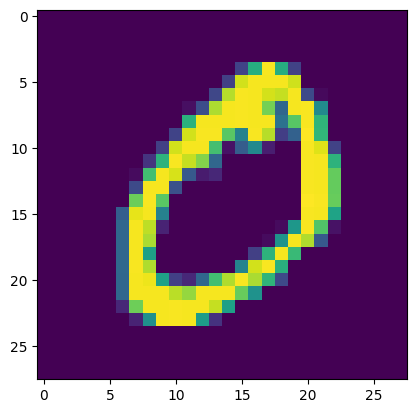

In [5]:
plt.imshow(x_train[1])

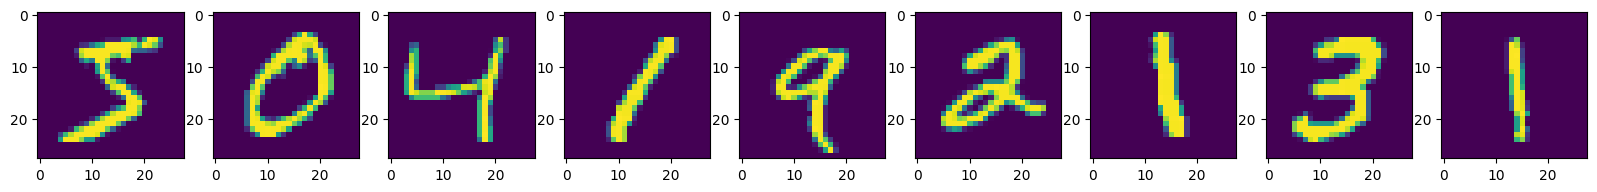

In [6]:
plt.figure(figsize = (20,9)) 

# plot first 9 datapoints from MNIST
for i in range(9):
 plt.subplot(1,9,i+1)
 plt.imshow(x_train[i])

## Preprocess Data

flatten all datapoints from (28x28) --> (784x1) and normalize

In [7]:
# flatten from 28x28 --> 784x1
x_train = x_train.reshape(len(x_train),-1)
x_test = x_test.reshape(len(x_test),-1)
print(x_train.shape)

(60000, 784)


In [8]:
# normalize
x_train = x_train / 255.0
np.min(x_train), np.max(x_train)

(0.0, 1.0)

In [9]:
# plt.figure(figsize = (20,9)) 

# # plot first 9 datapoints from MNIST
# for i in range(9):
#  plt.subplot(1,9,i+1)
#  plt.imshow(x_train[i].reshape((28,28)))

# K-Means

## Random Initialization

We can try different distance measures like L1, L2,L∞

Also do a plot to find best value of K and see if it is actually the most digit-like centroid

In [4]:
# kmeans
def l2_dist(x1,x2):
    distance = np.sqrt(np.sum((np.array(x1) - np.array(x2))**2))
    return distance

def l1_dist(x1,x2):
    distance = np.sum(abs(np.array(x1) - np.array(x2)))
    return distance

def linf_dist(x1,x2):
    distance = np.max(abs(np.array(x1) - np.array(x2)))
    return distance

In [2]:
def kmean(init_method, dist, max_iters=10, tol=0.05, K=10, do_plot=True):
  K = K # for 10 digits
  prev_error = float("inf")
  curr_error = float("inf")
  N = len(x_train)
  iter = 0
  cluster_assignments = np.array([-1]*len(x_train))
  tol=tol
  dist = dist

  # init centroids randomly
  if init_method == "random":
    centroids = x_train[np.random.choice(x_train.shape[0], K, replace=False)]
  elif init_method == "noise": # NOTE: not guaranteed to converge without setting np.seed
    centroids = np.array([np.random.rand(1, 784) for _ in range(K)])
  elif init_method == "1_to_10":
    # num to index: 0 = 1, 1 = 6, 2 = 5, 3 = 7, 4 = 2, 5 = 11, 6 = 13, 7 = 15, 8 = 17, 9 = 4
    centroids = x_train[np.array([1,6,5,7,2,11,13,15,17,4])] # digits 1-10 as centroids
  elif init_method == "maxmin":
    indices_3 = [np.random.choice(x_train.shape[0])]
    centroids = [x_train[indices_3[-1]]]

    while len(centroids) < K:
        # find dists for all points
        distances = np.array([min([l2_dist(x, centroid) for centroid in centroids]) for x in x_train])
        # pick max dist
        next_index = np.argmax(distances)
        centroids.append(x_train[next_index])
        indices_3.append(next_index)

    centroids = np.array(centroids)

  else:
    raise Exception("You didn't choose a valid initialization method: ['random', 'noise', '1_to_10']")

  if do_plot:
    # plot initial centroids
    _, axs = plt.subplots(1, K, figsize=(24, 2))
    for i in range(K):
      axs[i].imshow(centroids[i].reshape((28,28)))
      axs[i].set_title(f'Centroid #{i+1} (initial)')
      axs[i].axis('off')

  for i in range(max_iters):
    iter +=1
    for i in range(N):
      # Calculate the distance from the data point to each centroid
      dists = [dist(x_train[i], centroid) for centroid in centroids] 
      # Assign the data point to the cluster with the nearest centroid
      assignment = dists.index(min(dists))
      cluster_assignments[i] = assignment

    # update centroids
    for _ in range(K):
      if init_method == "noise":
        means = []
        for i in range(K):
          cluster_data = x_train[cluster_assignments == i]
          if not cluster_data.size > 0:
            mean = centroids[i].mean(axis=0)
          else:
            mean = cluster_data.mean(axis=0)
          means.append(mean)
        new_centroids = np.array(means)
      else: 
        new_centroids = np.array([x_train[cluster_assignments == i].mean(axis=0) for i in range(K)])
      centroids = new_centroids

    # calculate error
    meanerror = 0
    for i in range(N): meanerror += dist(x_train[i], centroids[cluster_assignments[i]])
    meanerror = meanerror / len(x_train)
    curr_error = meanerror

    if abs(curr_error - prev_error) <= tol: 
      break
    print(f"{iter=} err={curr_error}")
    prev_error = curr_error

    if do_plot:
      # plot centroids
      _, axs = plt.subplots(1, K, figsize=(26, 2))
      for i in range(K):
        axs[i].imshow(centroids[i].reshape((28,28)))
        axs[i].set_title(f'centroid={i+1} iter={iter}')
        axs[i].axis('off')

  # Show the plot
  plt.show()

  return meanerror

# l2_dist experiments

iter=1 err=6.59155914214599
iter=2 err=6.408354243881892
iter=3 err=6.322623923804384
iter=4 err=6.271472169569904


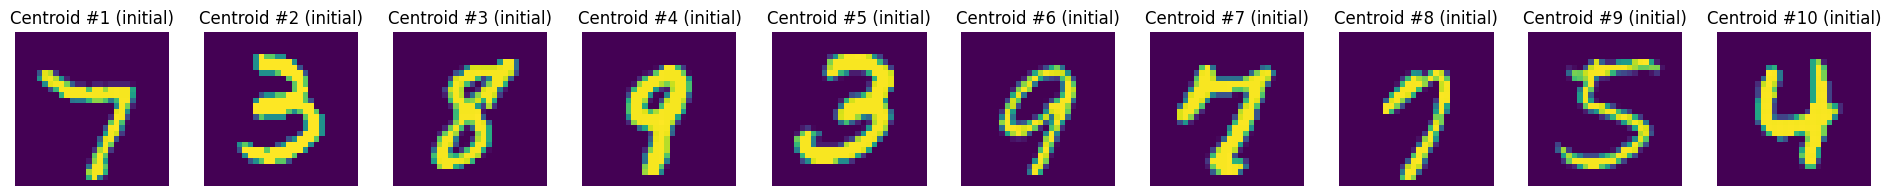

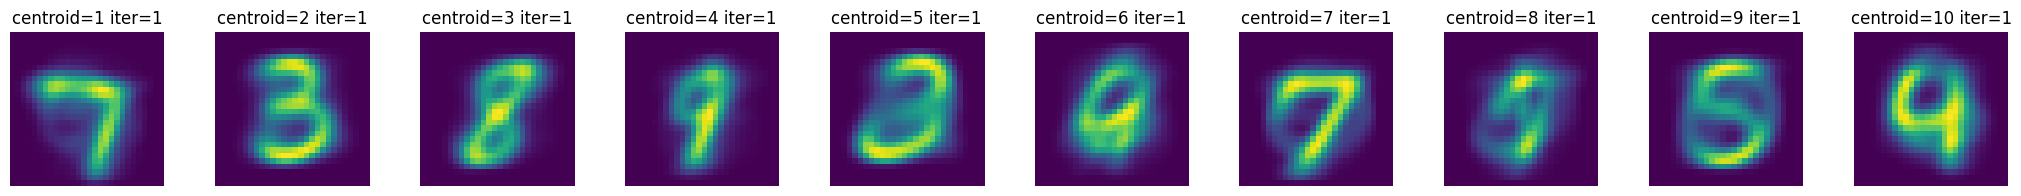

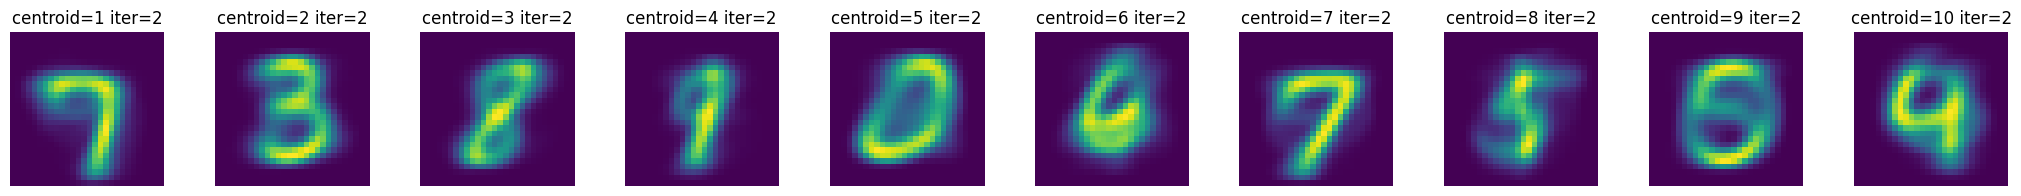

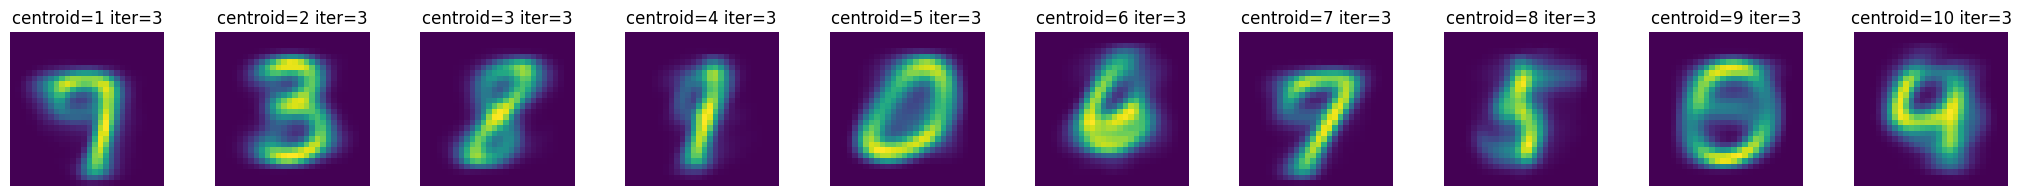

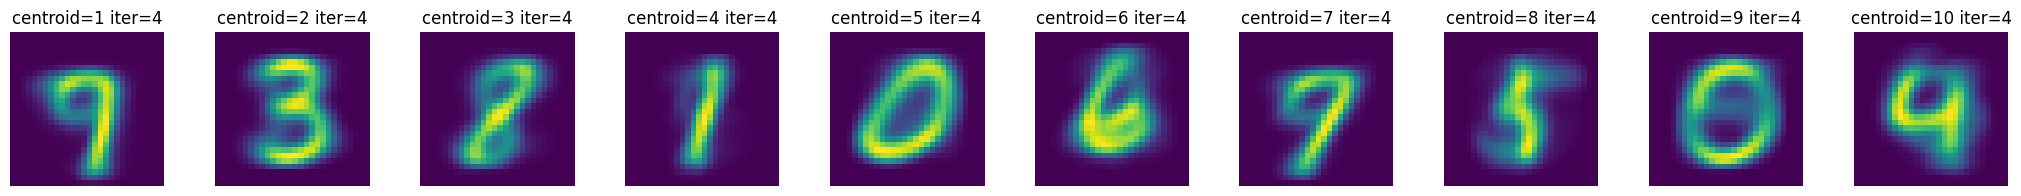

In [12]:
kmean(init_method="random", dist=l2_dist, max_iters=10, tol=0.05)

iter=1 err=7.036384974059402
iter=2 err=6.606923108542027
iter=3 err=6.444503486750168
iter=4 err=6.349427293007117


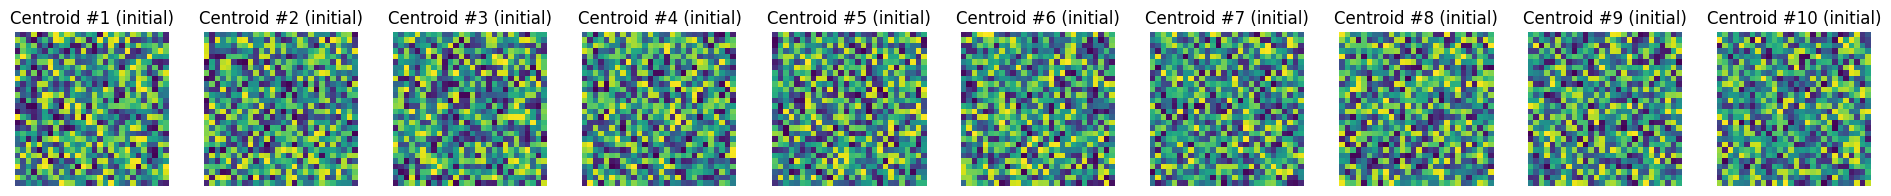

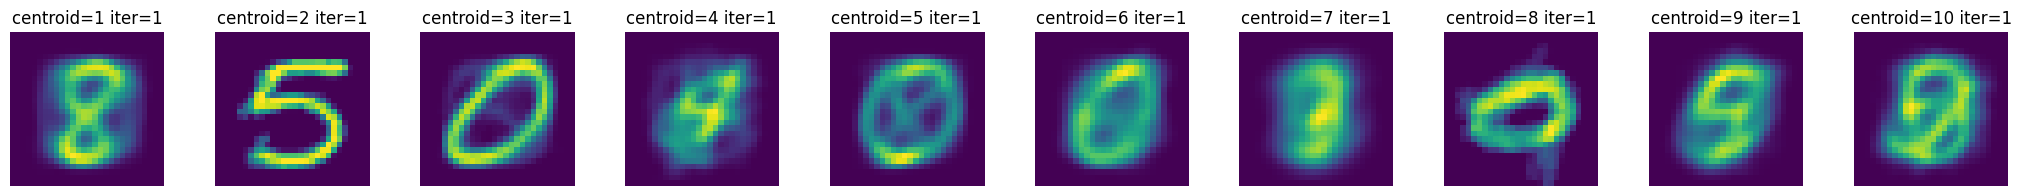

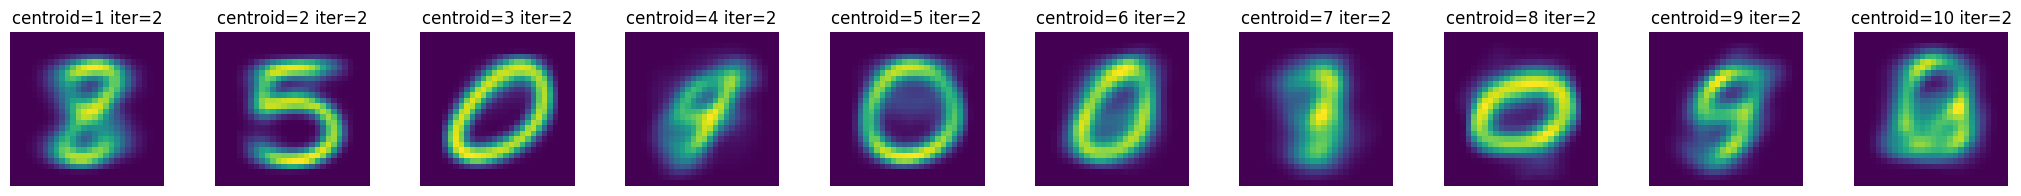

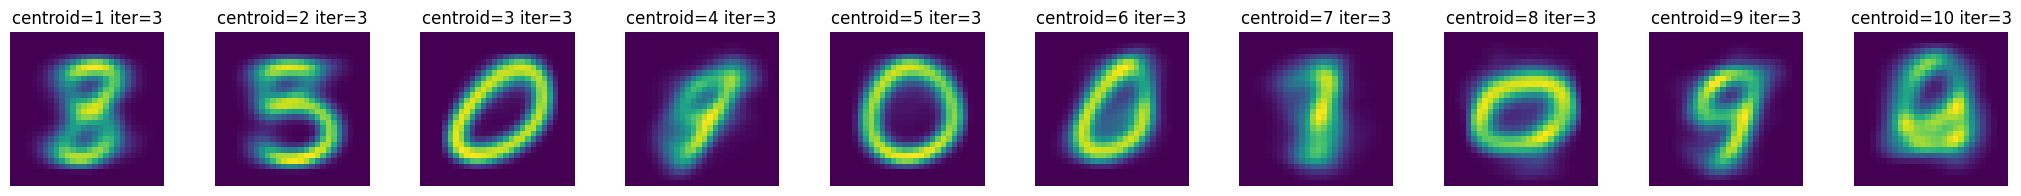

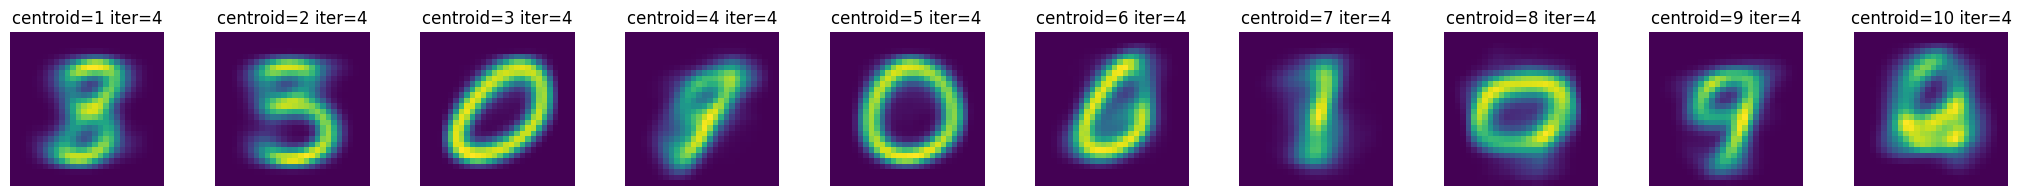

In [13]:
kmean(init_method="noise", dist=l2_dist, max_iters=10, tol=0.05)

iter=1 err=6.354974454144897
iter=2 err=6.22491153687481


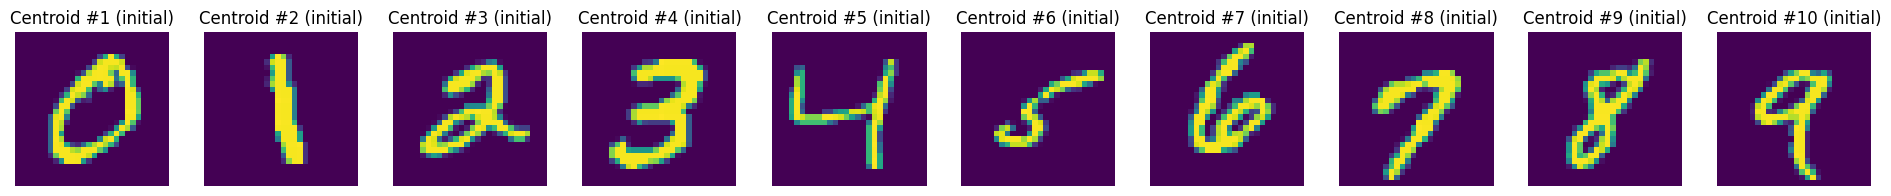

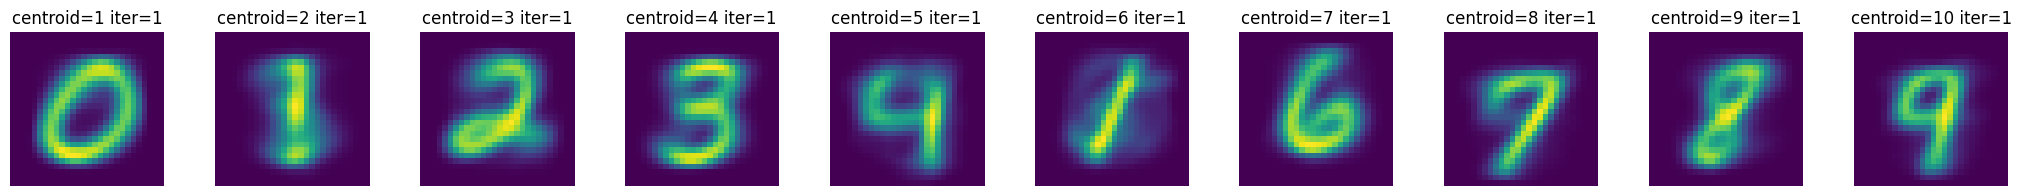

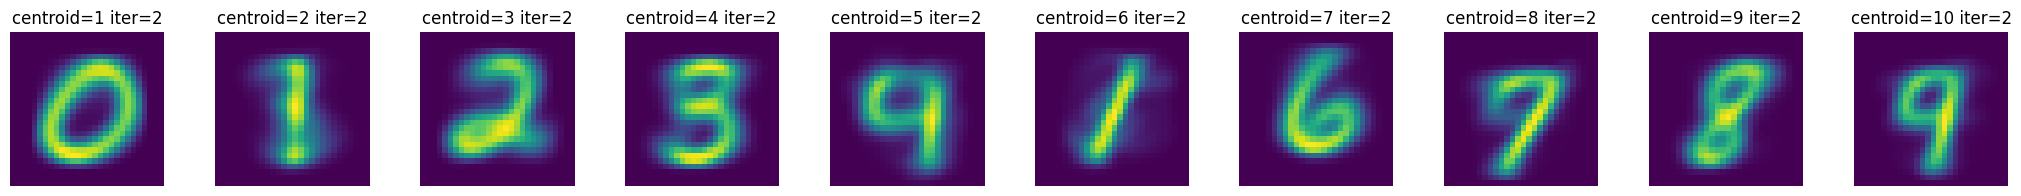

In [14]:
kmean(init_method="1_to_10", dist=l2_dist, max_iters=10, tol=0.05)

# l1_dist experiments

iter=1 err=99.73509533868116
iter=2 err=95.78875409703654
iter=3 err=94.92962072806934
iter=4 err=94.53417426829382
iter=5 err=94.27406974154597
iter=6 err=94.02568933850739
iter=7 err=93.80871448961229
iter=8 err=93.58141795682099
iter=9 err=93.32365877754022
iter=10 err=93.01569261711634


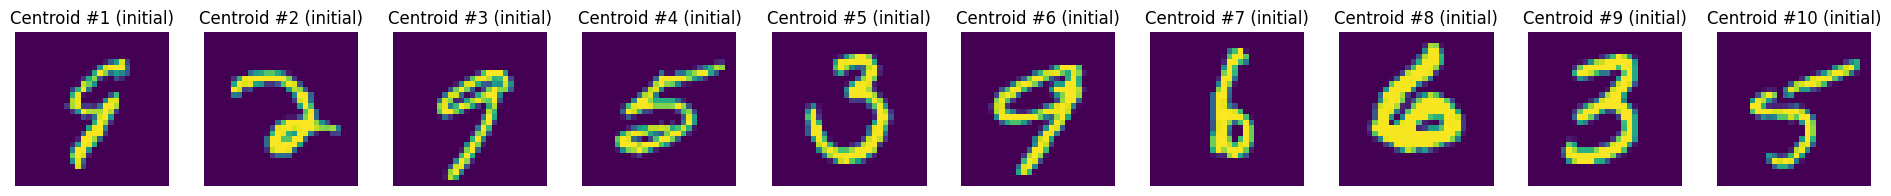

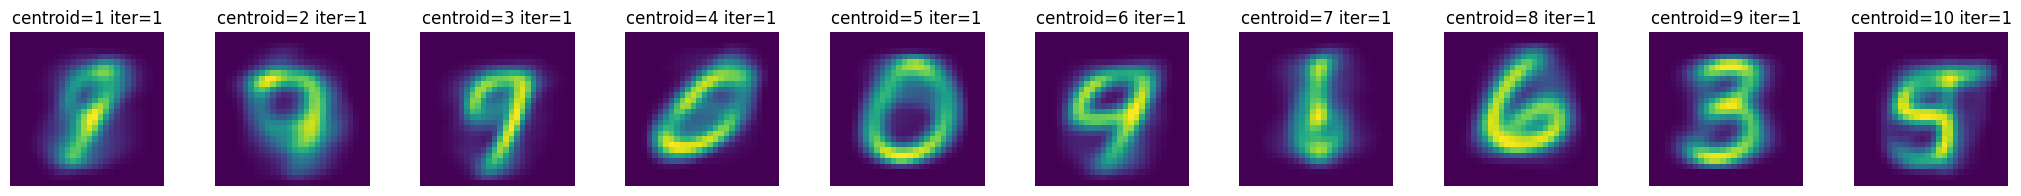

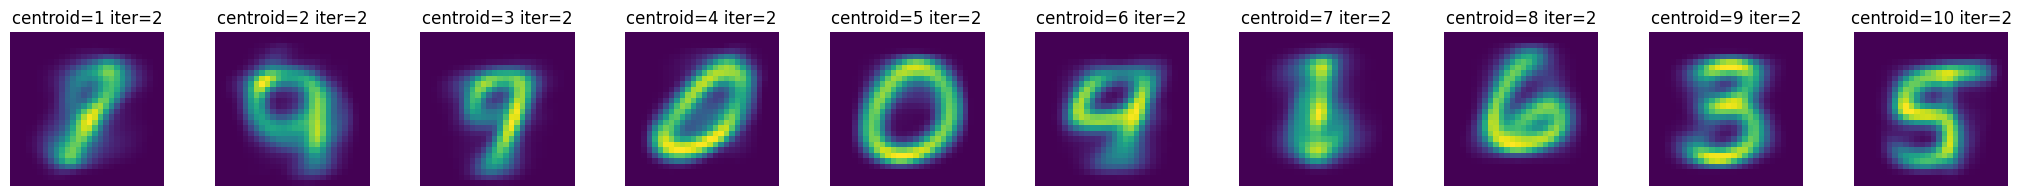

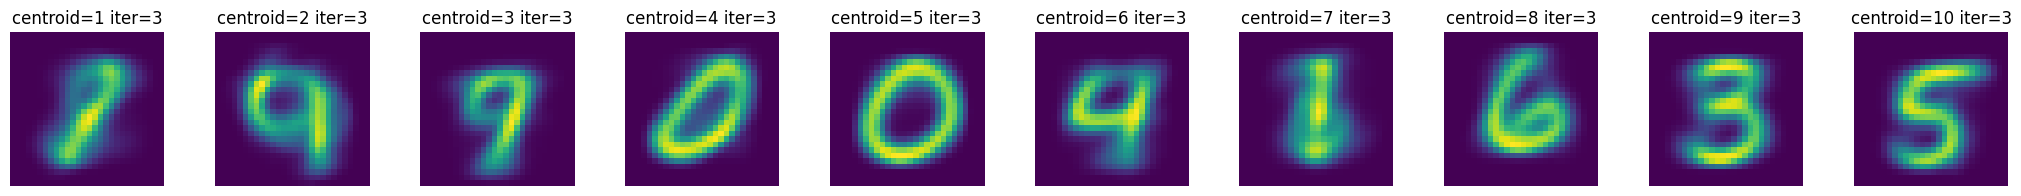

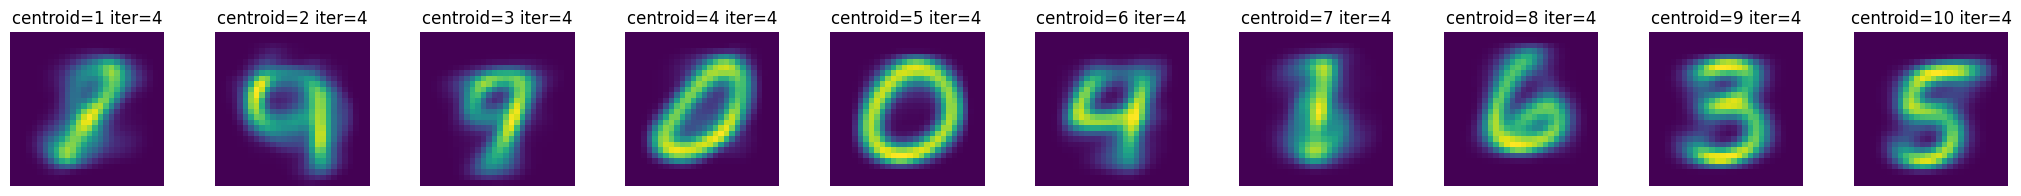

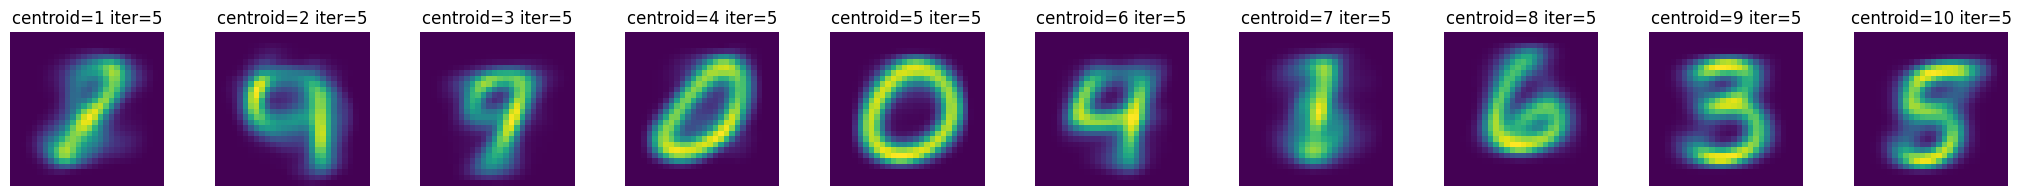

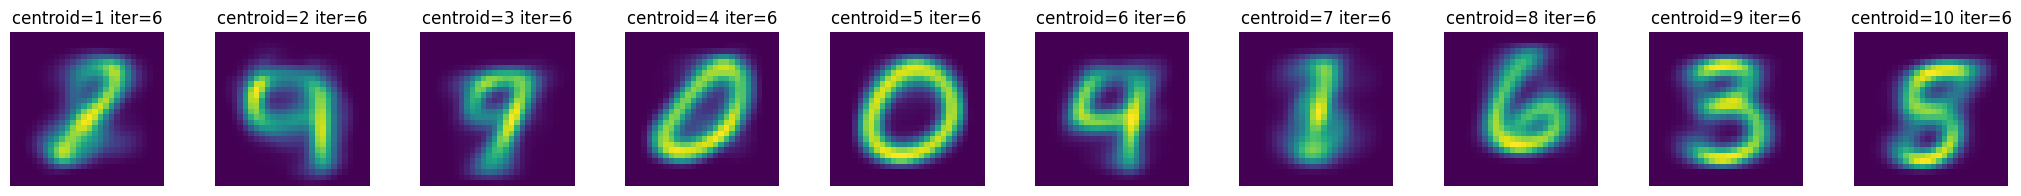

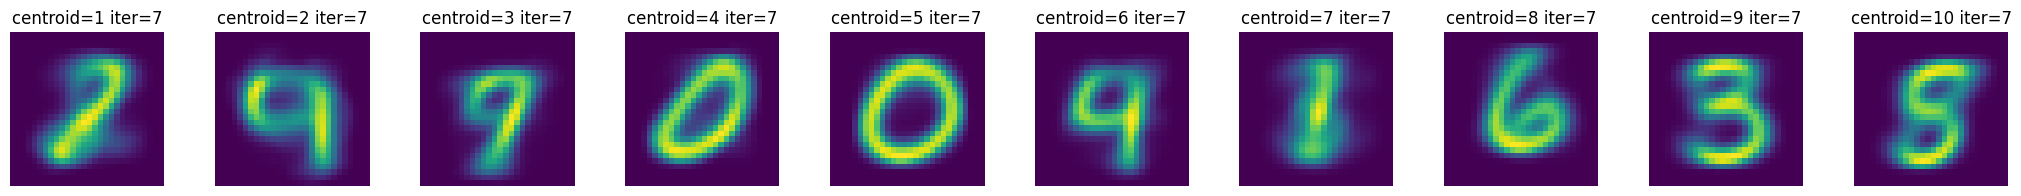

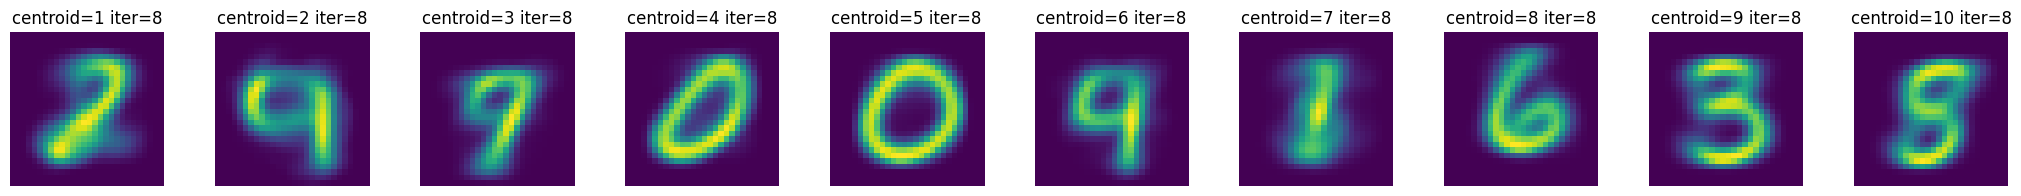

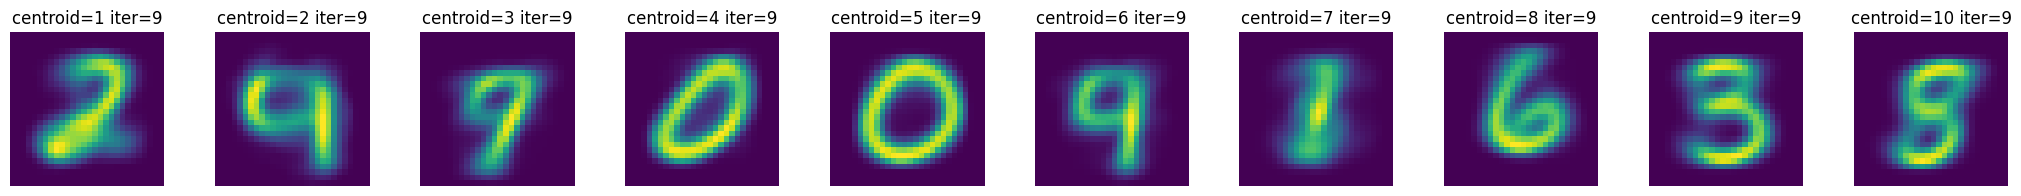

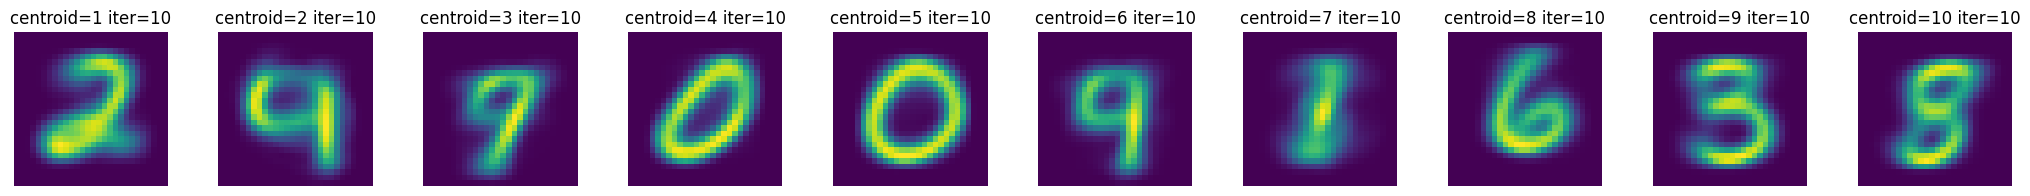

In [15]:
kmean(init_method="random", dist=l1_dist, max_iters=10, tol=0.05)

iter=1 err=111.58975329749256
iter=2 err=100.59317047333042
iter=3 err=97.77781705221281
iter=4 err=96.34668204181311
iter=5 err=95.69432983013357
iter=6 err=95.39905972021805
iter=7 err=95.1955798118328
iter=8 err=94.98384308204896
iter=9 err=94.81770988526311
iter=10 err=94.70423594002253


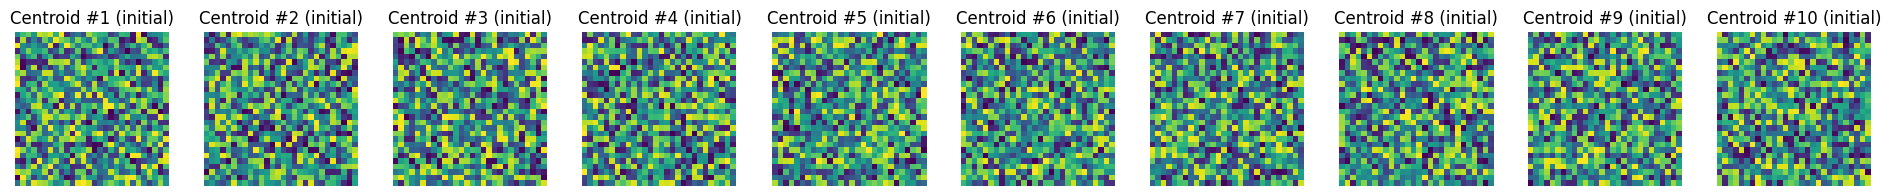

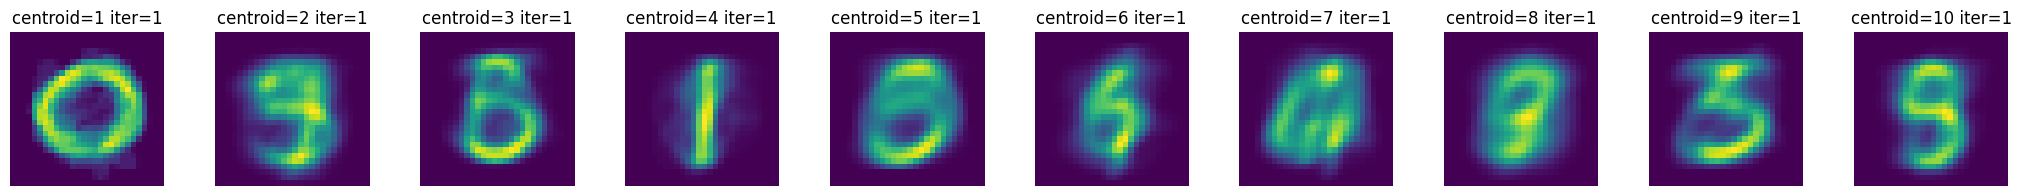

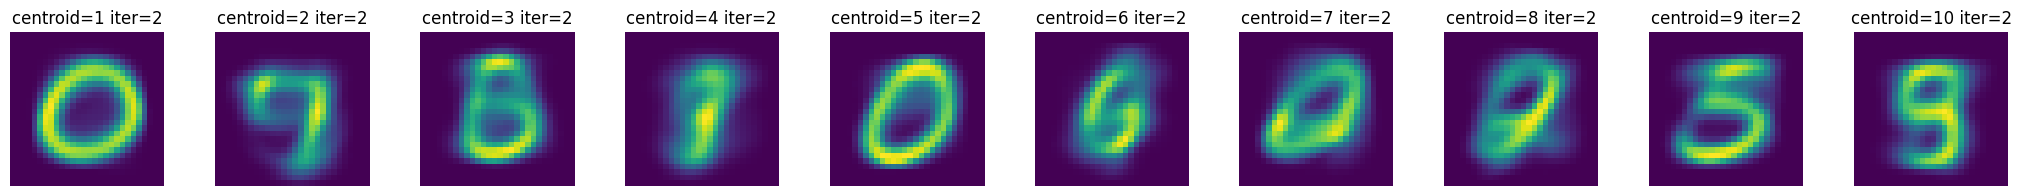

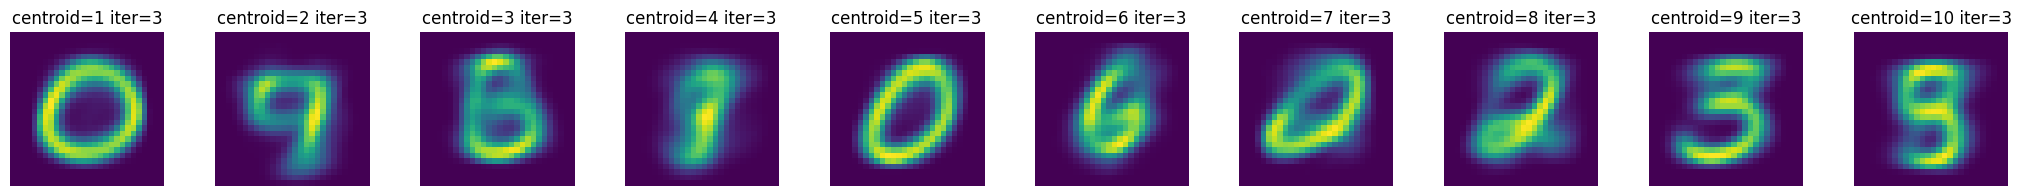

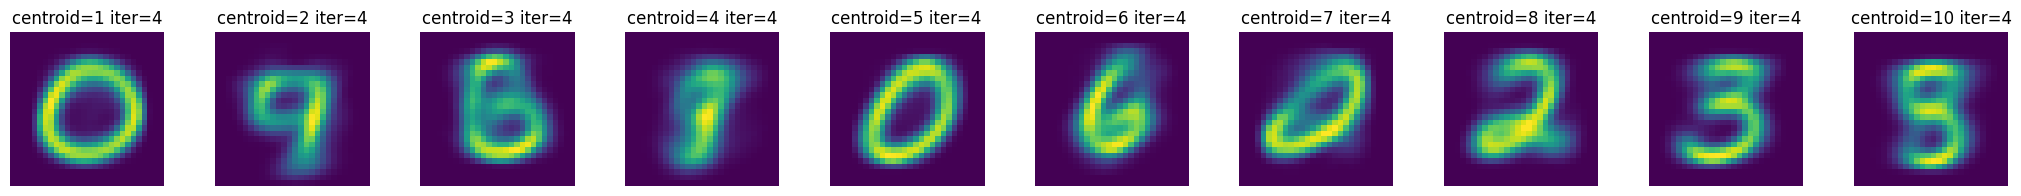

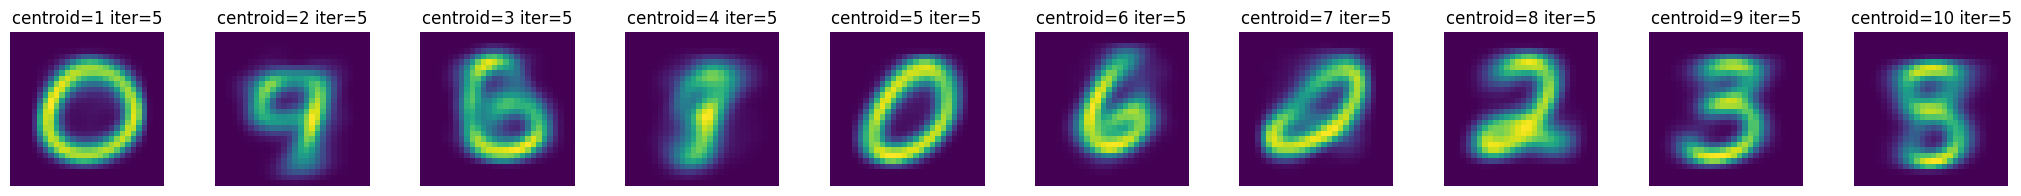

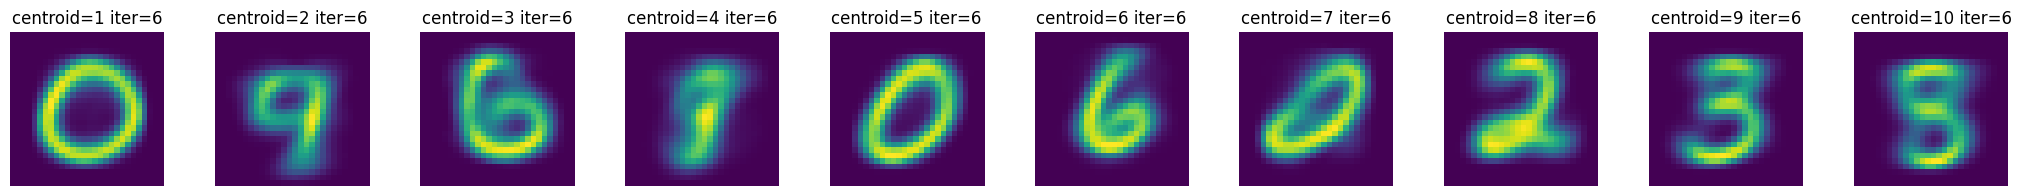

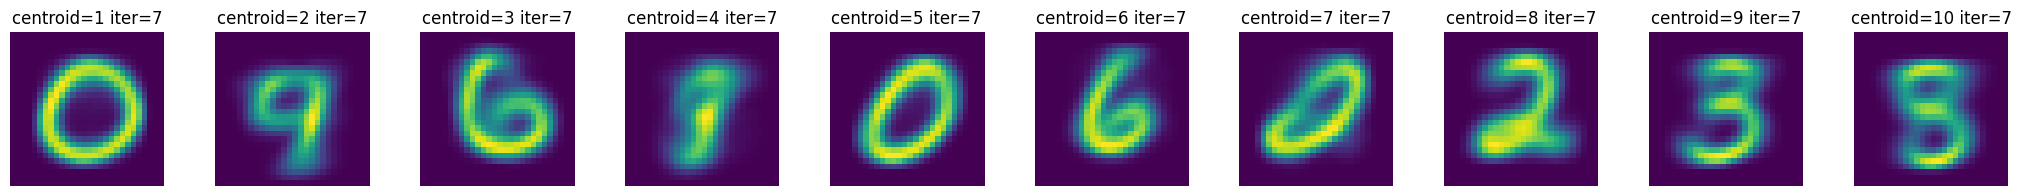

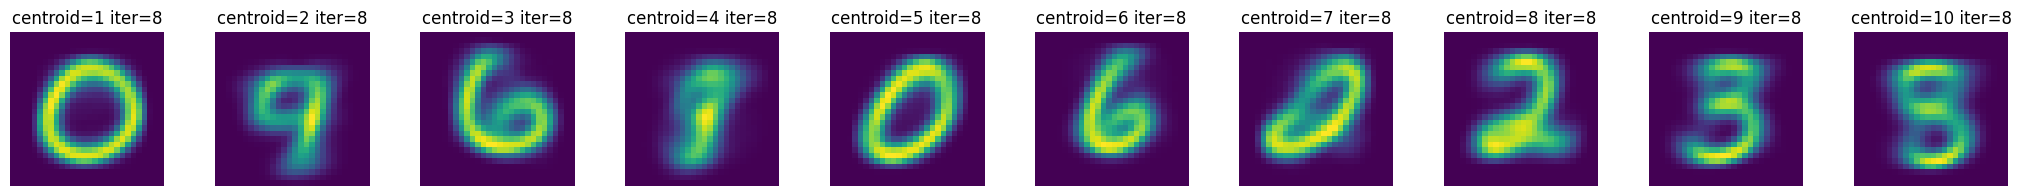

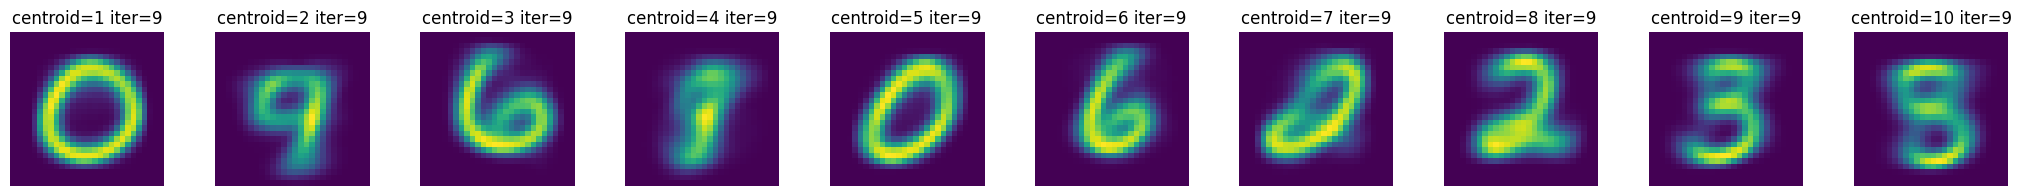

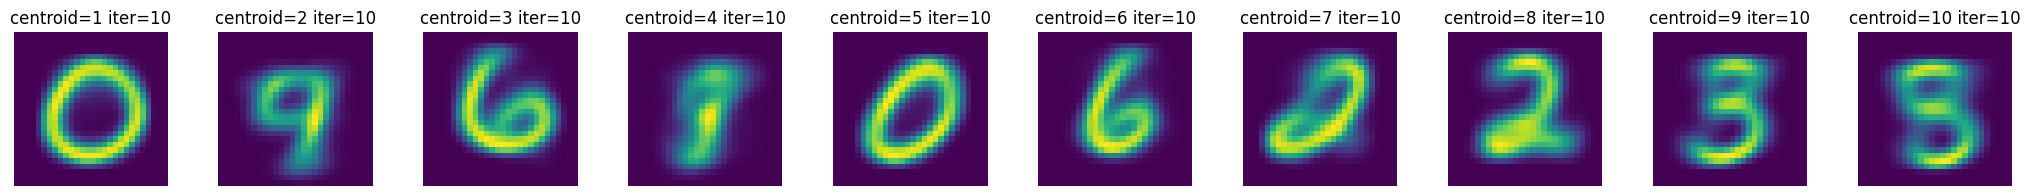

In [16]:
np.random.seed(4022)
kmean(init_method="noise", dist=l1_dist, max_iters=10, tol=0.05)

iter=1 err=95.96288323988956
iter=2 err=93.01033475505628
iter=3 err=92.64774513969253
iter=4 err=92.59156870109112


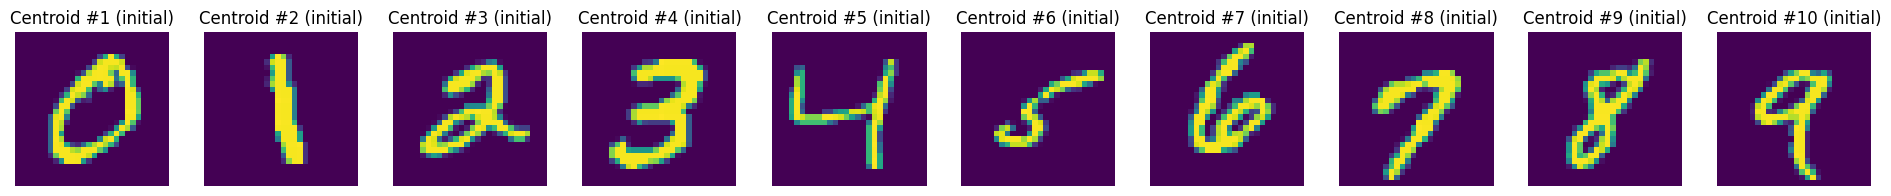

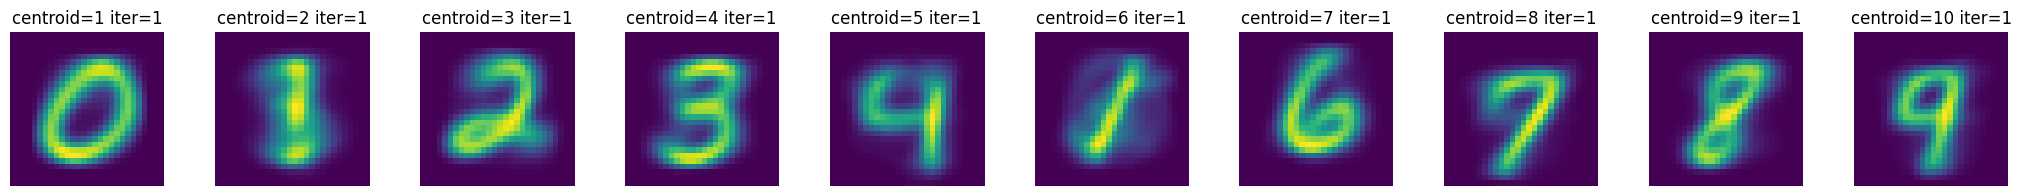

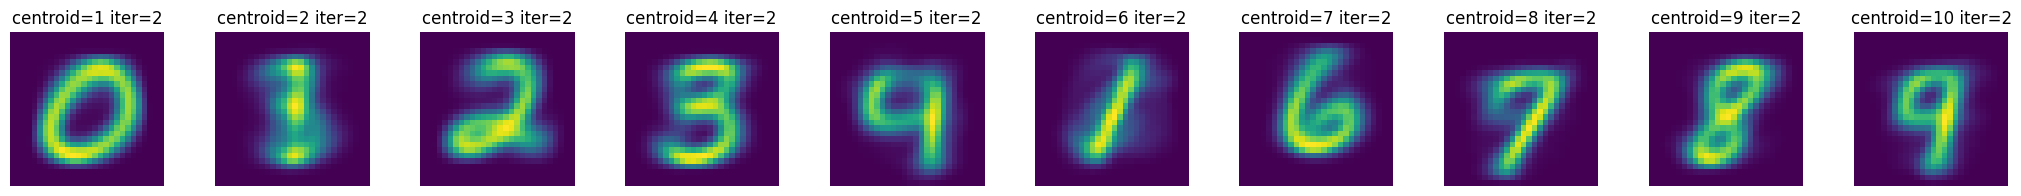

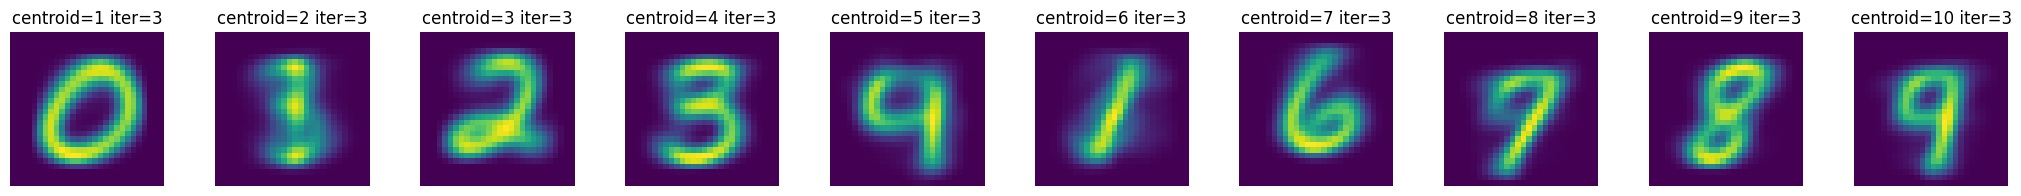

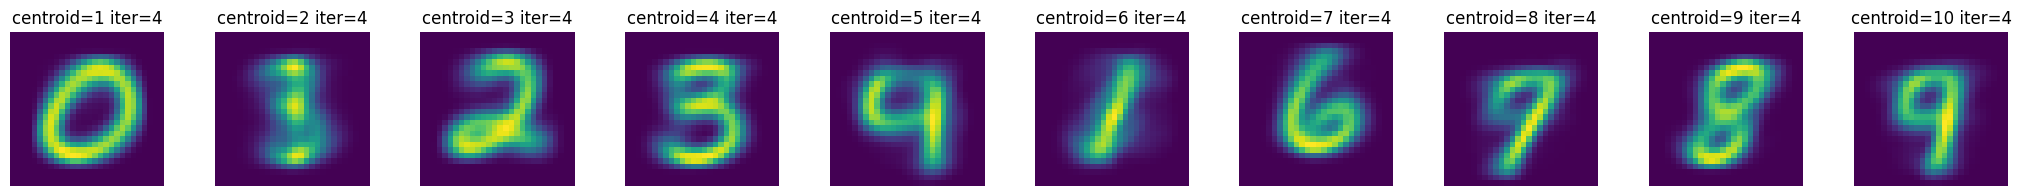

In [17]:
kmean(init_method="1_to_10", dist=l1_dist, max_iters=10, tol=0.05)

# L-infinity experiments

iter=1 err=0.9016962001075187


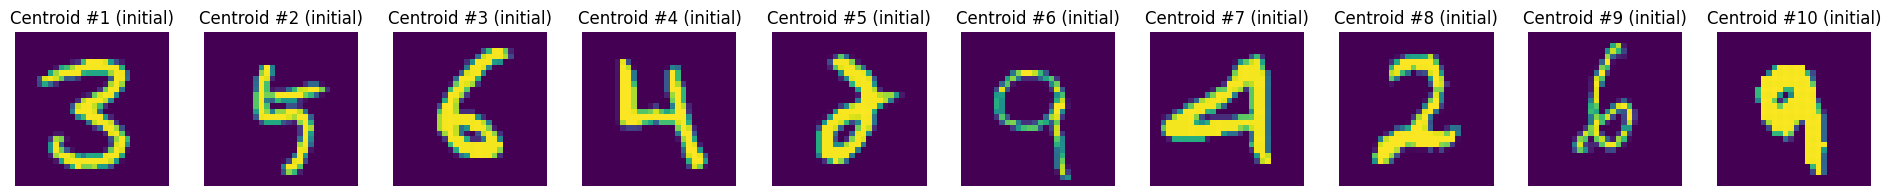

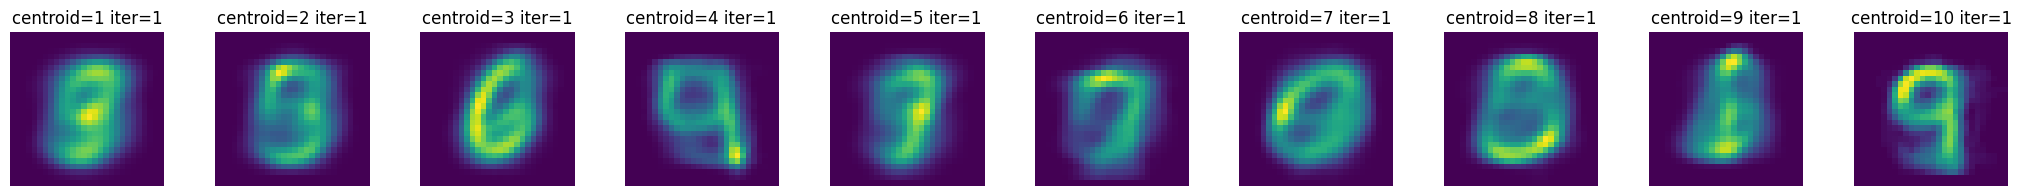

In [18]:
kmean(init_method="random", dist=linf_dist, max_iters=10, tol=0.05)

iter=1 err=0.8966340890205421


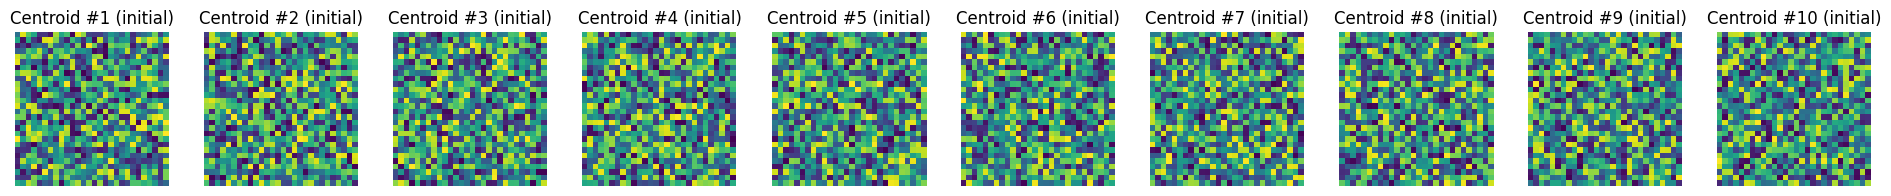

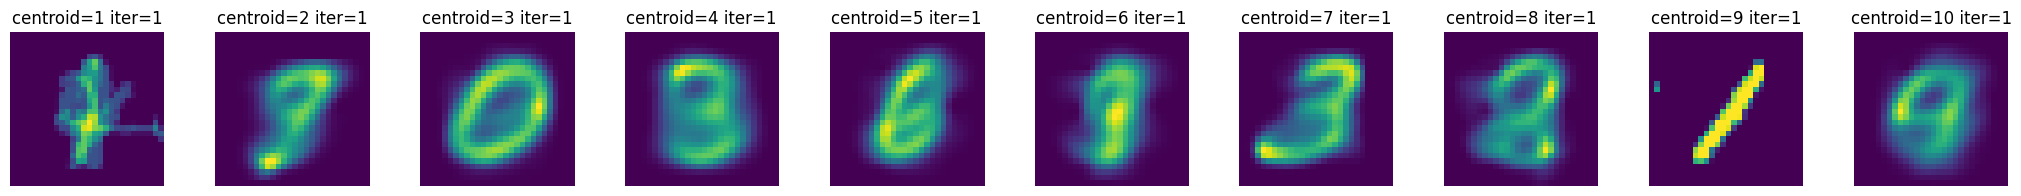

In [19]:
np.random.seed(42)
kmean(init_method="noise", dist=linf_dist, max_iters=10, tol=0.05)

iter=1 err=0.9024297531770076


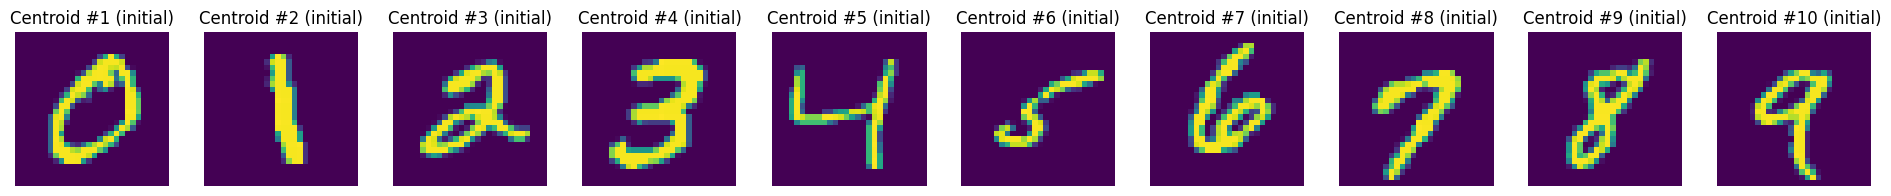

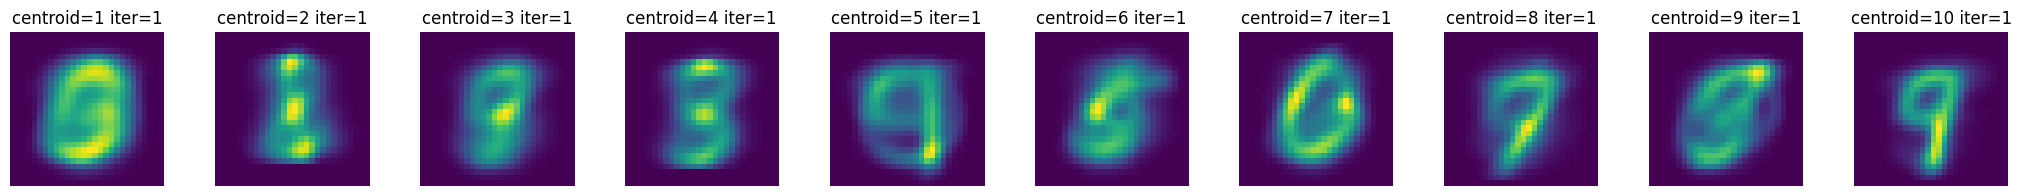

In [20]:
kmean(init_method="1_to_10", dist=linf_dist, max_iters=10, tol=0.05)

# Tolerance experiments

iter=1 err=6.540293496834466
iter=2 err=6.3472369438309935
iter=3 err=6.288214201201884


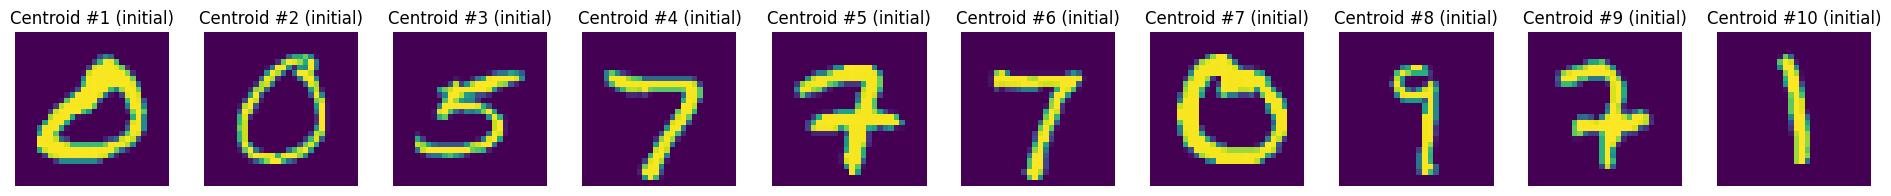

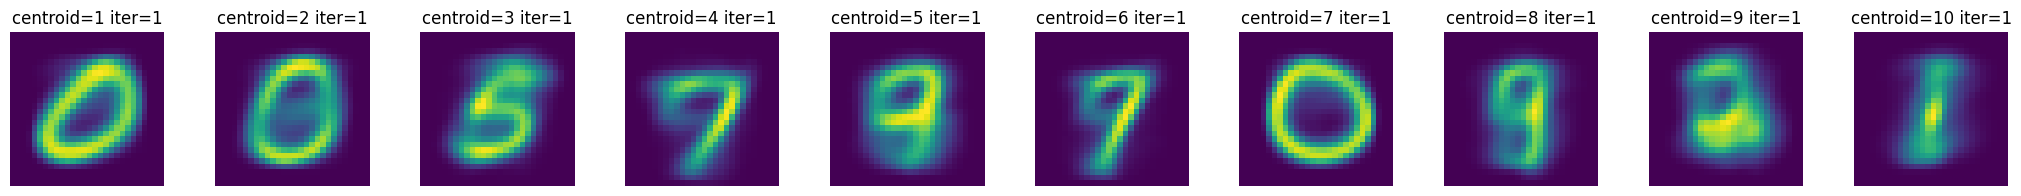

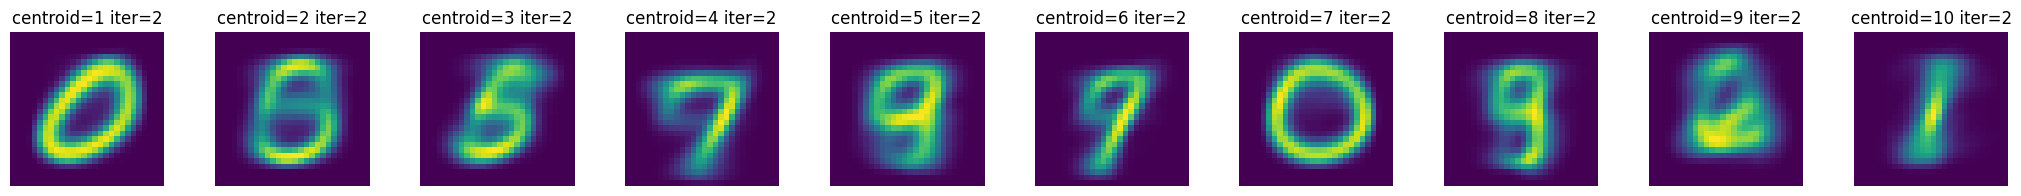

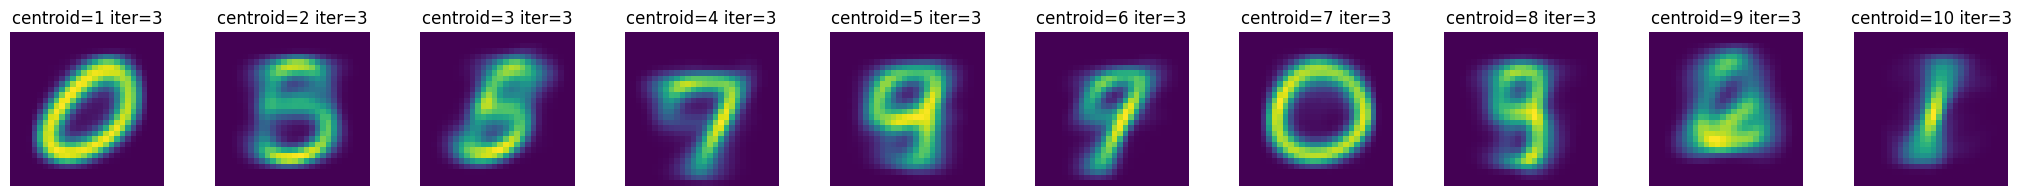

In [21]:
kmean(init_method="random", dist=l2_dist, max_iters=10, tol=0.05)

iter=1 err=6.61857524457176


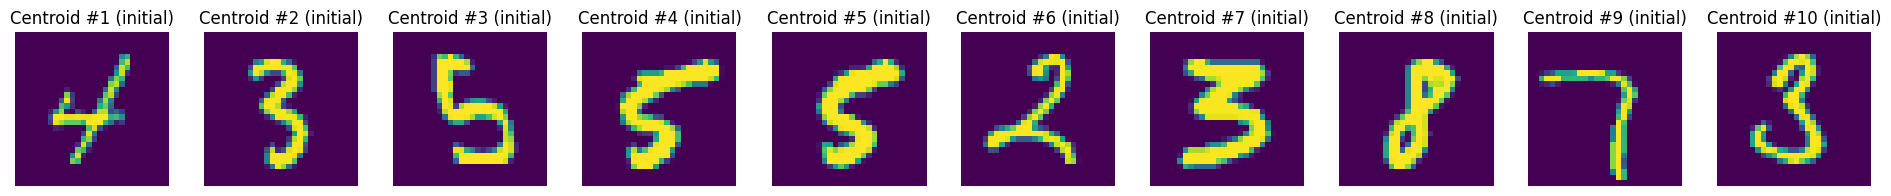

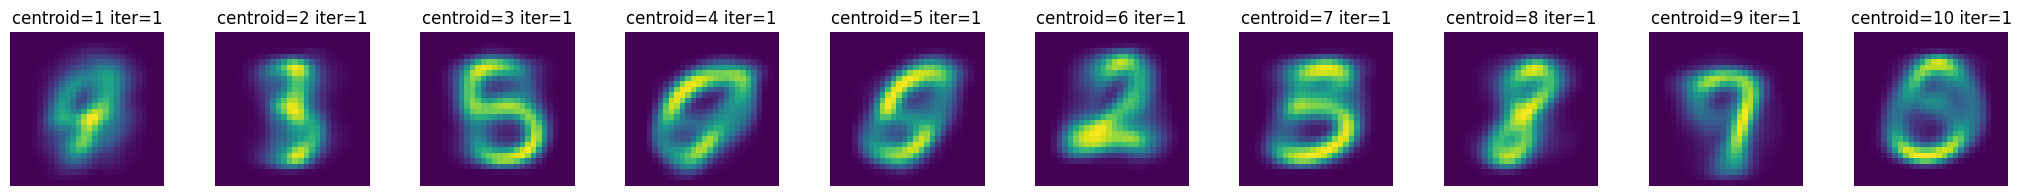

In [22]:
kmean(init_method="random", dist=l2_dist, max_iters=10, tol=0.5)

iter=1 err=6.658764583737739
iter=2 err=6.43749670628992
iter=3 err=6.323582063450581
iter=4 err=6.2682311544683325
iter=5 err=6.243221883307311
iter=6 err=6.229912435693314
iter=7 err=6.220435817720218
iter=8 err=6.213080554794744
iter=9 err=6.20762996267965
iter=10 err=6.203923304295463


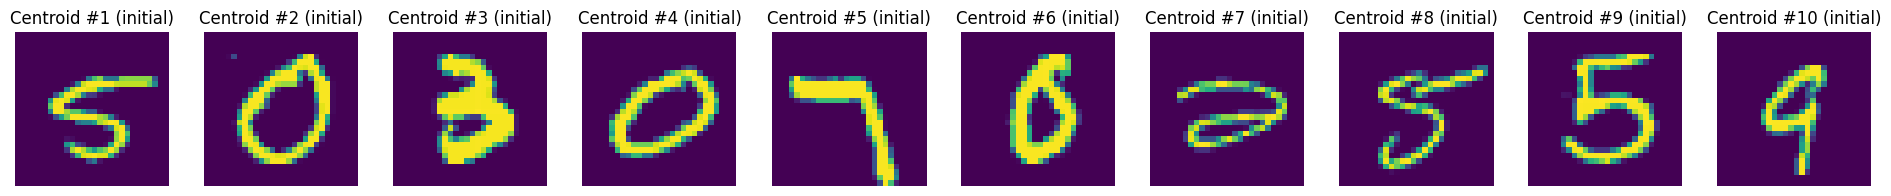

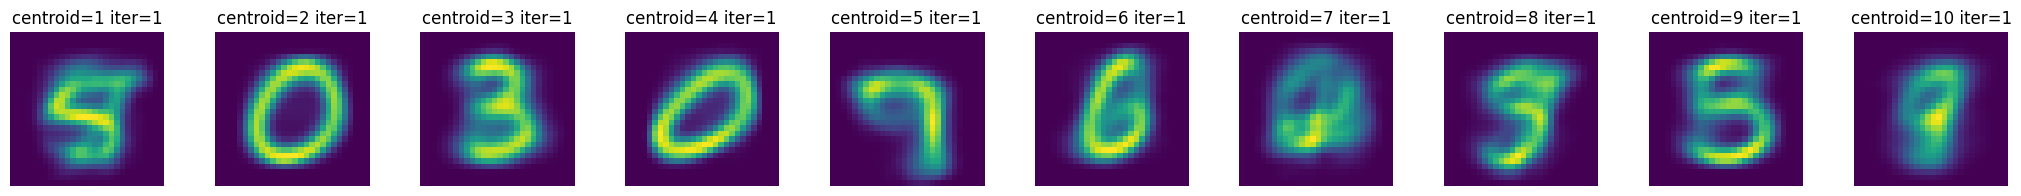

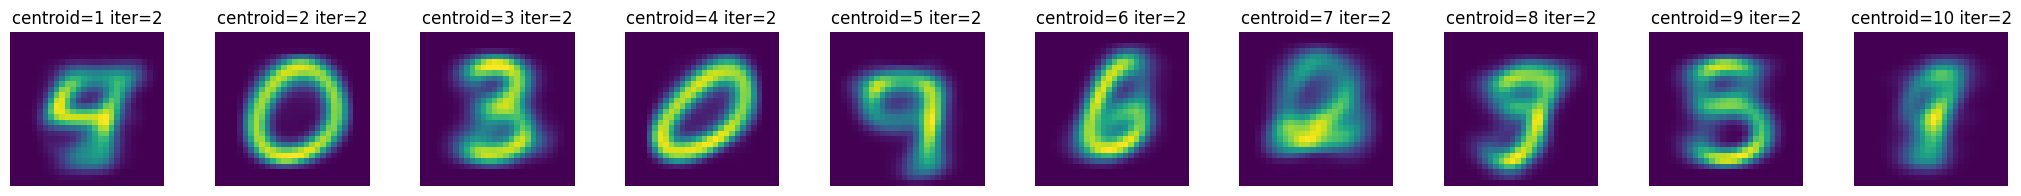

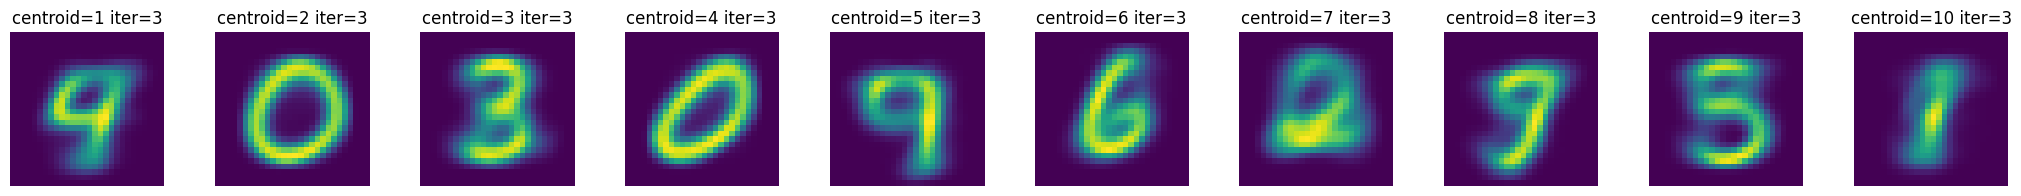

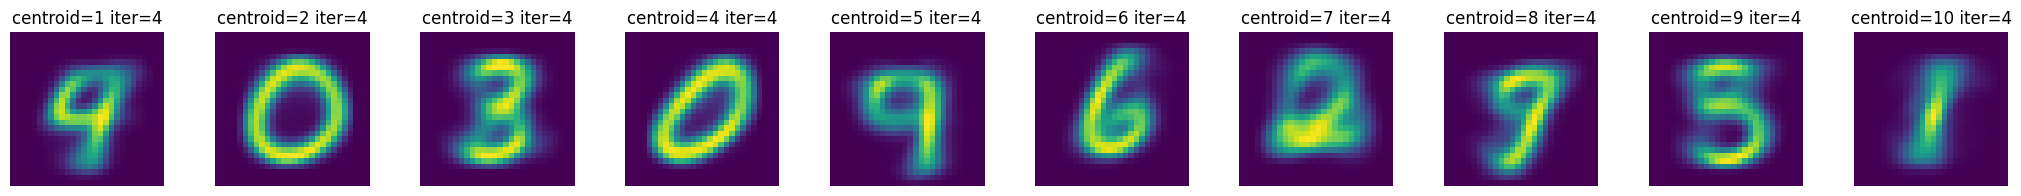

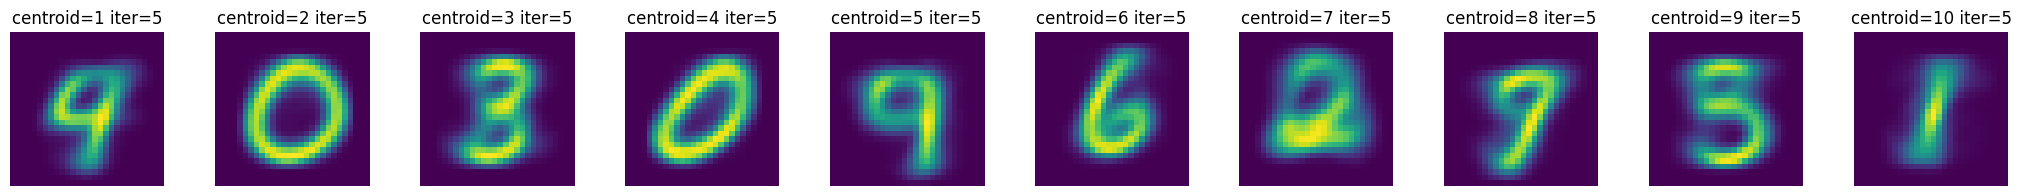

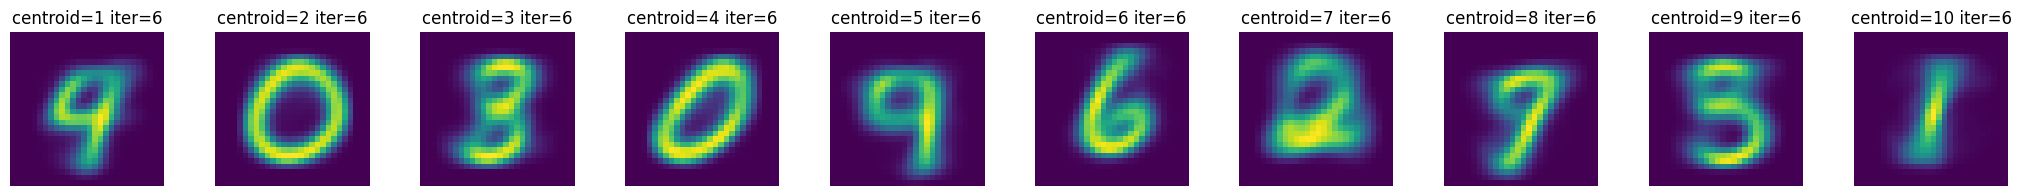

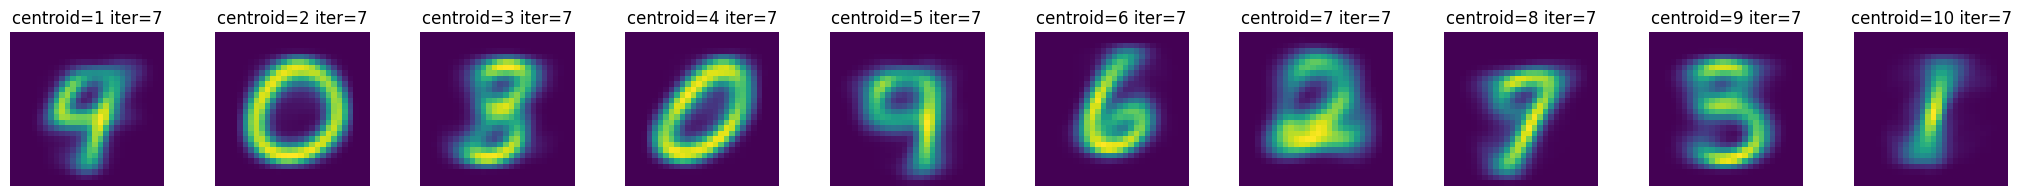

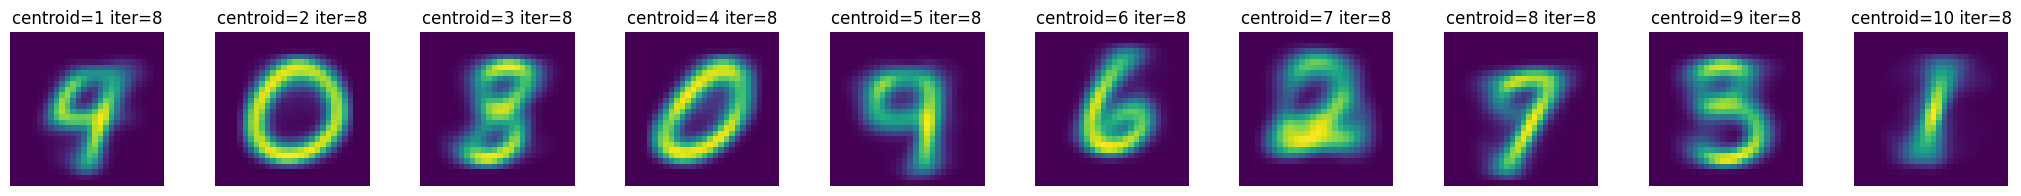

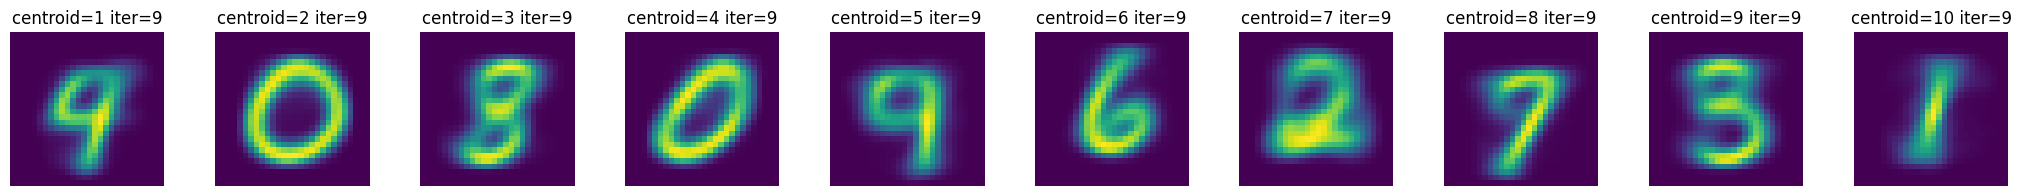

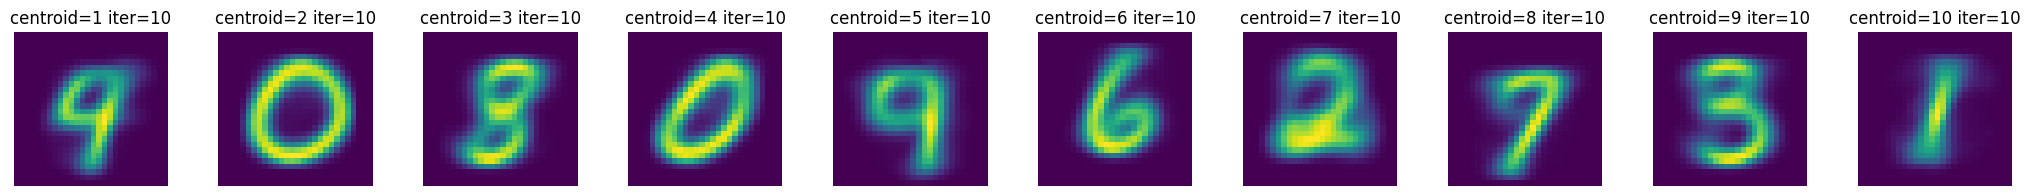

In [23]:
kmean(init_method="random", dist=l2_dist, max_iters=10, tol=0.00001)

# K-Clusters experiments

iter=1 err=6.58492763572183
iter=2 err=6.435160467501543
iter=3 err=6.344330386370504
iter=4 err=6.258875584381909


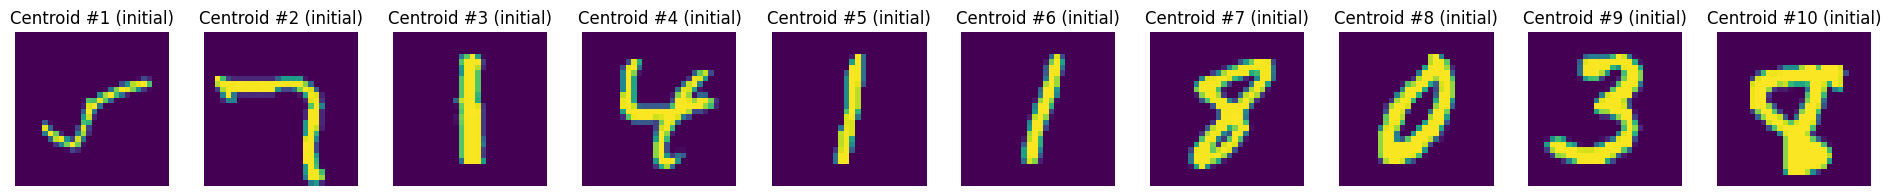

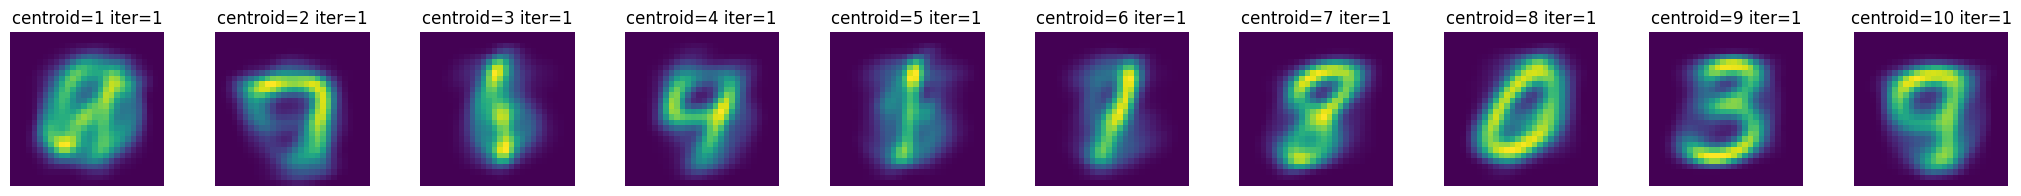

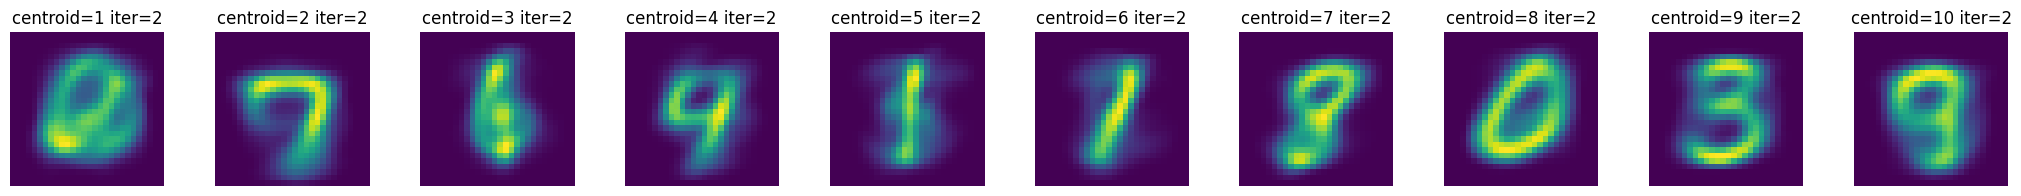

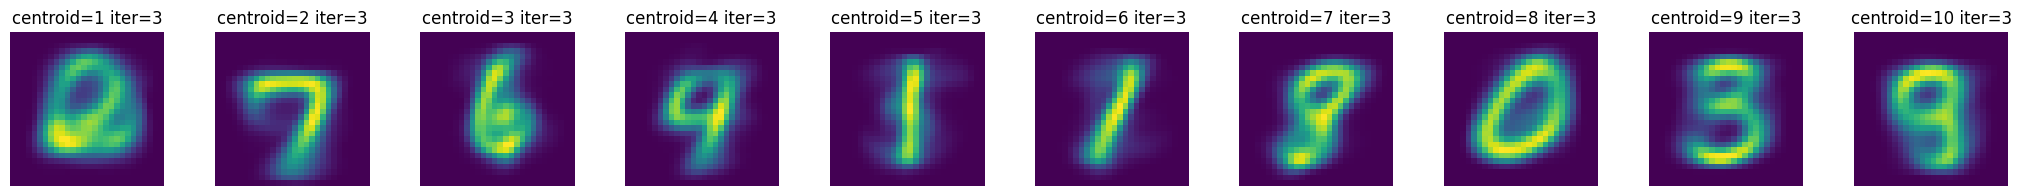

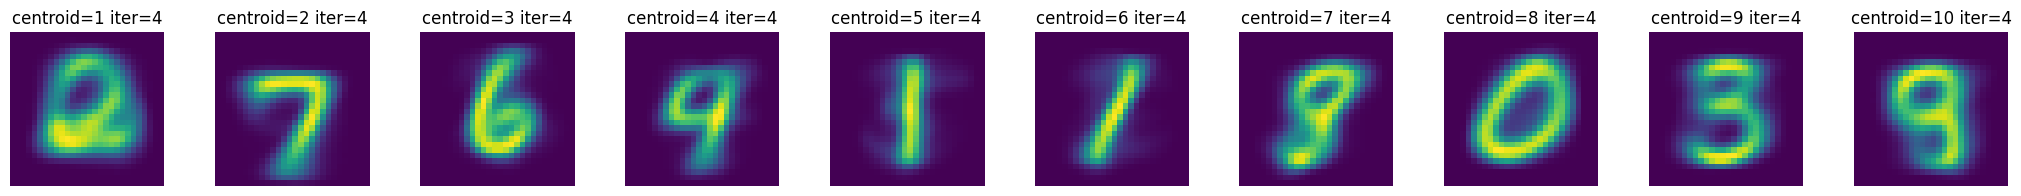

In [24]:
kmean(init_method="random", dist=l2_dist, max_iters=10, tol=0.05, K=10) # baseline

iter=1 err=6.886677581348795
iter=2 err=6.675522677223337
iter=3 err=6.615442418823974


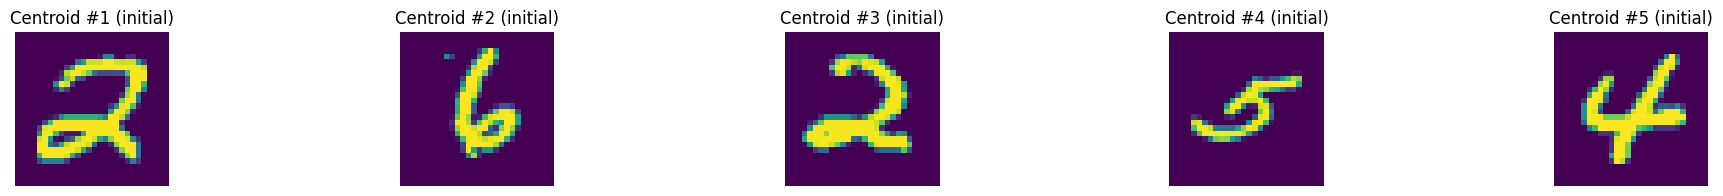

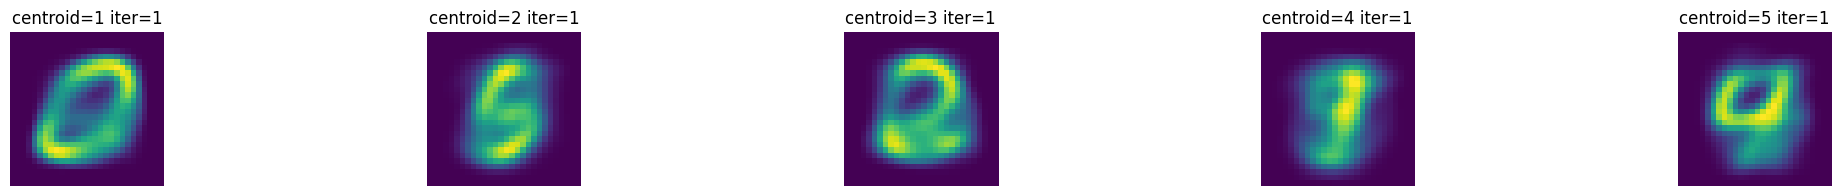

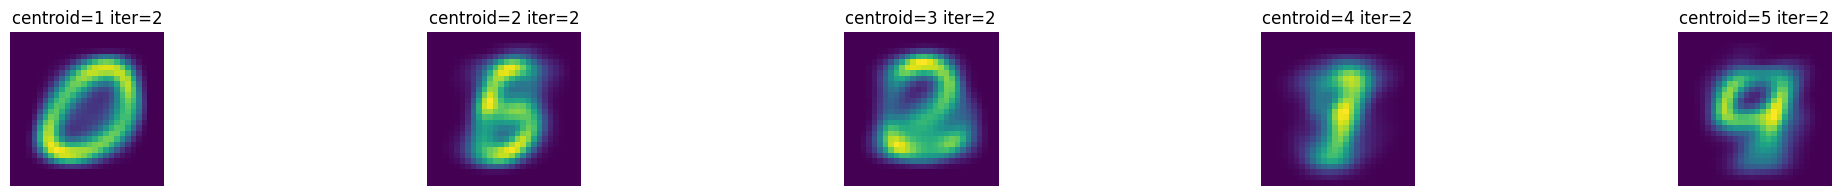

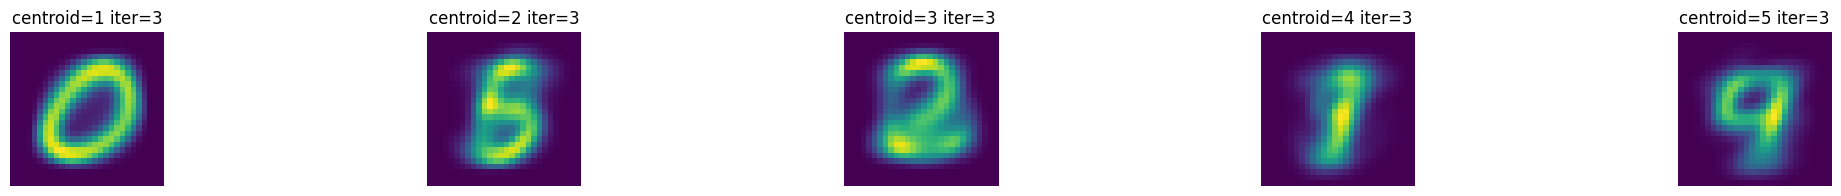

In [25]:
kmean(init_method="random", dist=l2_dist, max_iters=10, tol=0.05, K=5)

iter=1 err=6.3331002385951995
iter=2 err=6.1534164566096665
iter=3 err=6.098693355090032


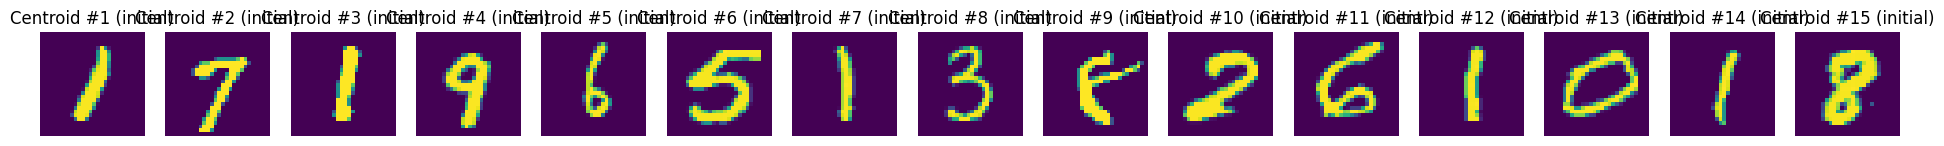

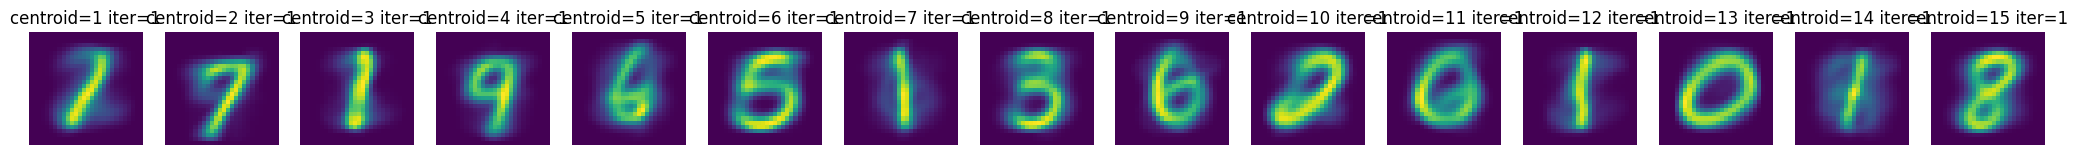

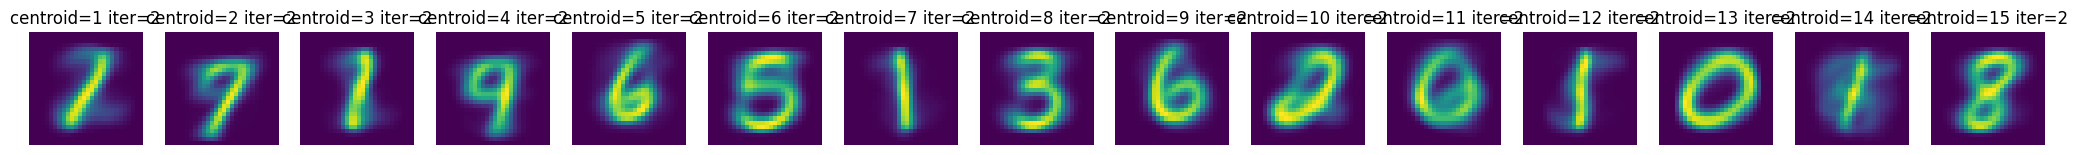

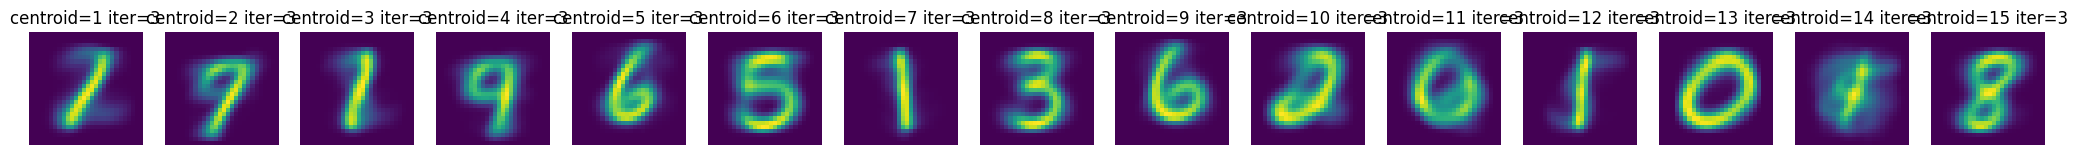

In [26]:
kmean(init_method="random", dist=l2_dist, max_iters=10, tol=0.05, K=15)

iter=1 err=6.260311073876855
iter=2 err=6.049263236799249
iter=3 err=5.978590730762695


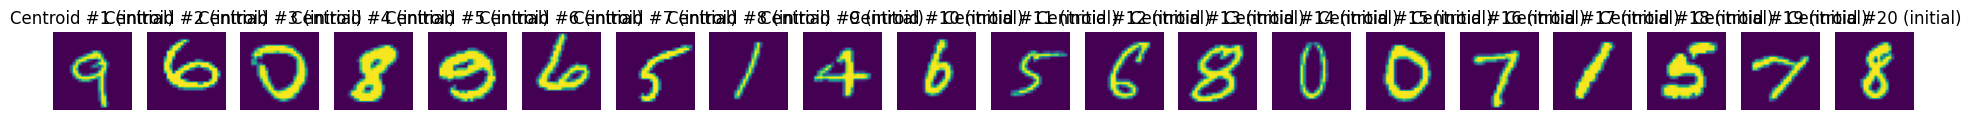

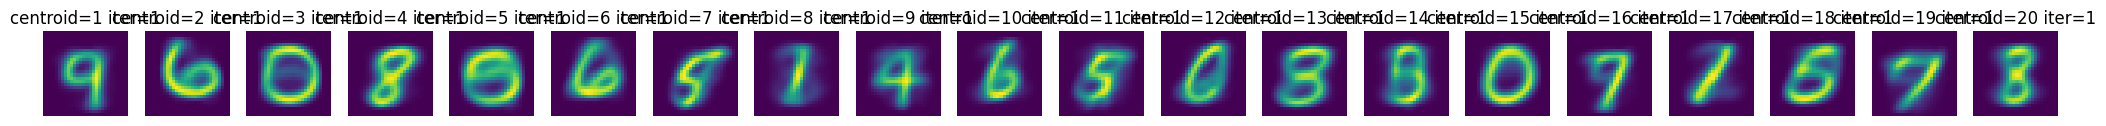

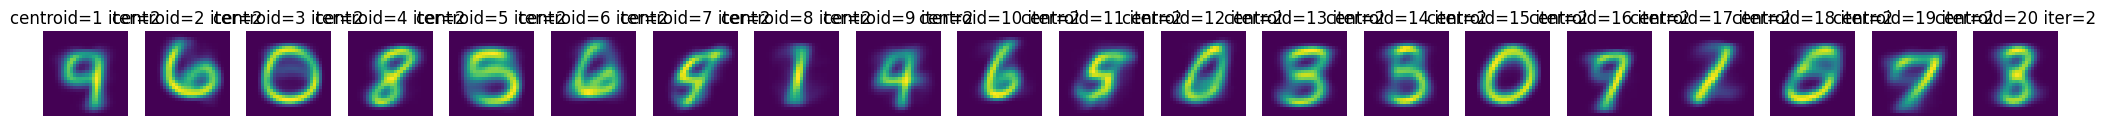

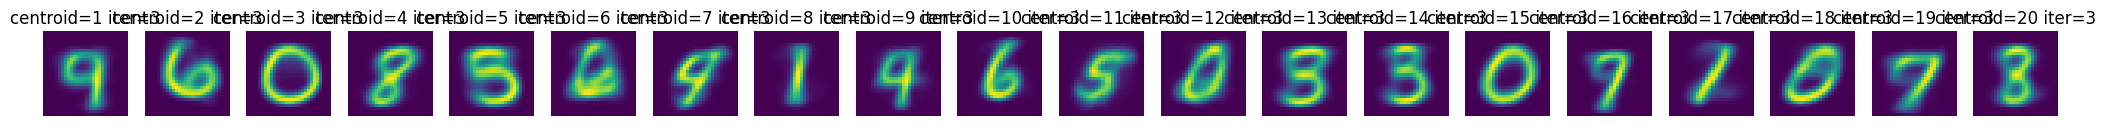

In [27]:
kmean(init_method="random", dist=l2_dist, max_iters=10, tol=0.05, K=20)

## Hierarchical clustering
Do hierarchical clustering to get to k clusters from a (small) subset of the data, then randomly select one point from each cluster.


In [28]:
K_2 = 10
x_train = x_train.reshape(len(x_train),-1)
x_test = x_test.reshape(len(x_test),-1)
cluster_assignments_2 = np.array([-1] * len(x_train))

# find small subset of data to init clusters
indices_2 = np.random.choice(x_train.shape[0], size=2*K_2, replace=False)
subset_2 = x_train[indices_2]

# track indices
original_indices_2 = [[index] for index in indices_2]

# calculate pair distance
distances_2 = np.array([[np.linalg.norm(subset_2[i] - subset_2[j]) for j in range(subset_2.shape[0])] for i in range(subset_2.shape[0])])

while len(subset_2) > K_2:
    min_dist_2 = np.inf
    pair_to_merge_2 = (0, 1)

    # find closest pair
    for i in range(len(subset_2)):
        for j in range(i + 1, len(subset_2)):
            if distances_2[i, j] < min_dist_2:
                min_dist_2 = distances_2[i, j]
                pair_to_merge_2 = (i, j)

    # merge closest pair
    new_point_2 = (subset_2[pair_to_merge_2[0]] + subset_2[pair_to_merge_2[1]]) / 2

    # update subset
    new_indices_2 = list(set(range(len(subset_2))) - set(pair_to_merge_2))
    subset_2 = np.vstack([subset_2[new_indices_2], new_point_2])

    # update original indices tracking
    merged_indices = original_indices_2[pair_to_merge_2[0]] + original_indices_2[pair_to_merge_2[1]]
    original_indices_2 = [original_indices_2[idx] for idx in new_indices_2] + [merged_indices]

    # recalculate distance matrix
    new_distances_2 = np.zeros((len(subset_2), len(subset_2)))
    for i in range(len(subset_2)):
        for j in range(i + 1, len(subset_2)):
            new_distances_2[i, j] = new_distances_2[j, i] = np.linalg.norm(subset_2[i] - subset_2[j])
        new_distances_2[i, i] = np.inf # makes sure not the same point
    distances_2 = new_distances_2

# calculate centroids
centroids_2 = np.zeros((K_2, x_train.shape[1]))
for i in range(K_2):
    points_indices = np.hstack(original_indices_2[i])
    centroids_2[i] = np.mean(x_train[points_indices], axis=0)

centroids_2.shape

(10, 784)

1 inf
2 5.54461662075331
3 1.5730111255251416
4 0.6114235260846854
5 0.4582640993584235
6 0.46291487851244284
7 0.270644666957196
8 0.13140892277309035
9 0.078228776587558
10 0.05443549745901777


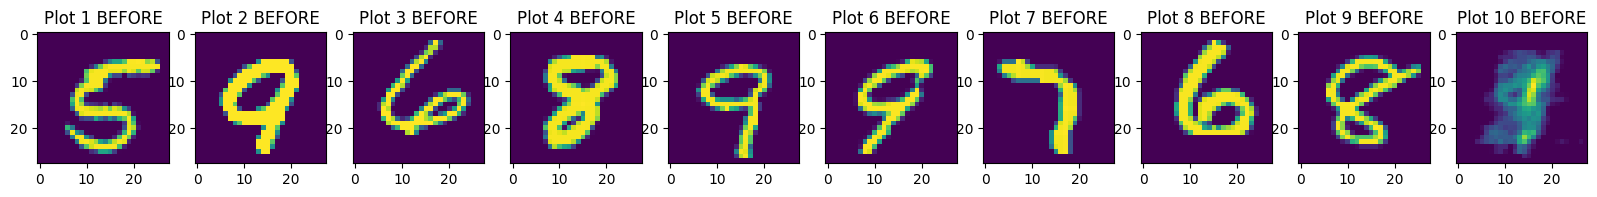

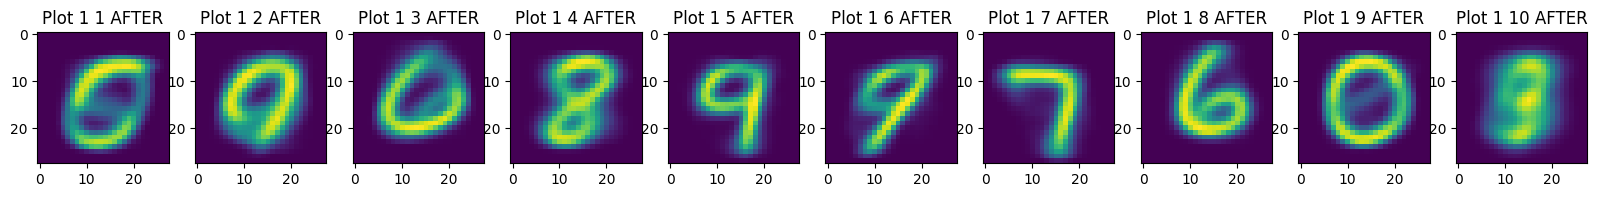

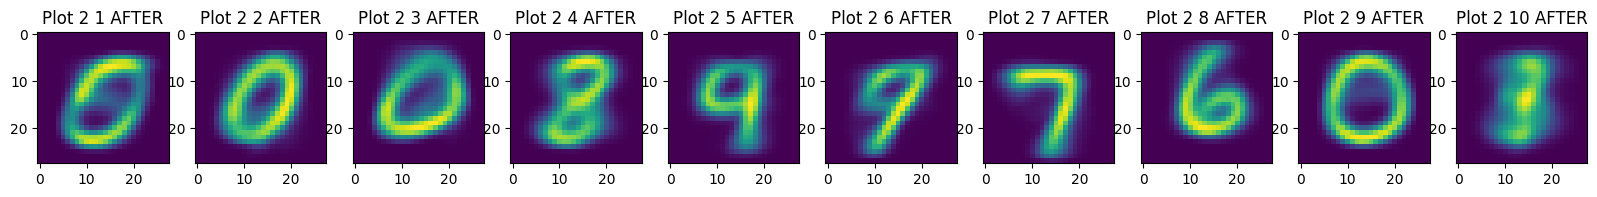

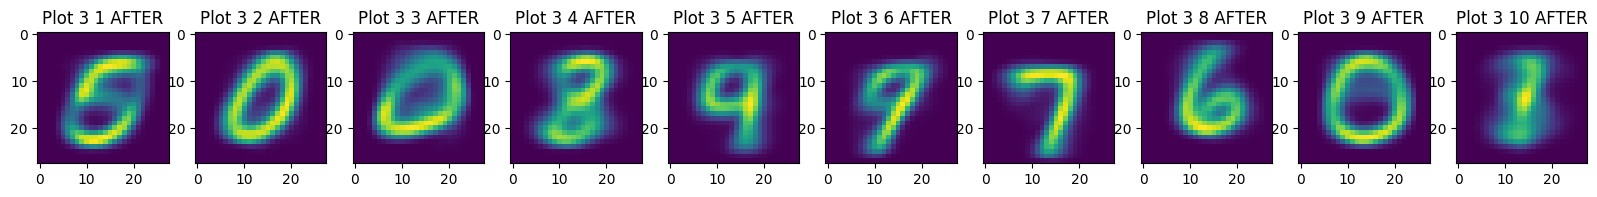

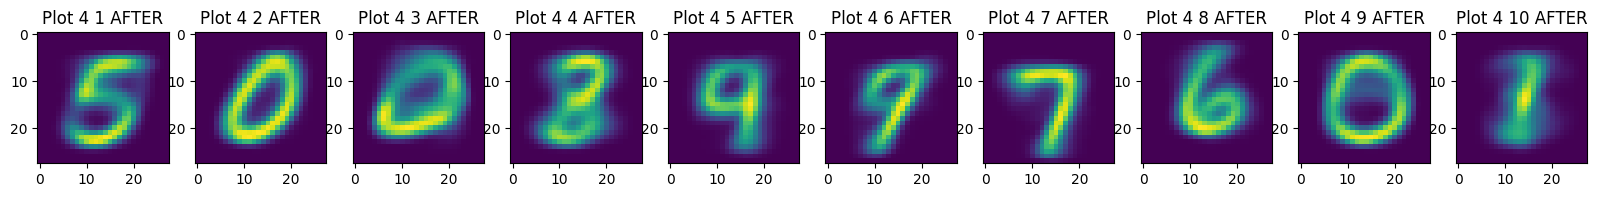

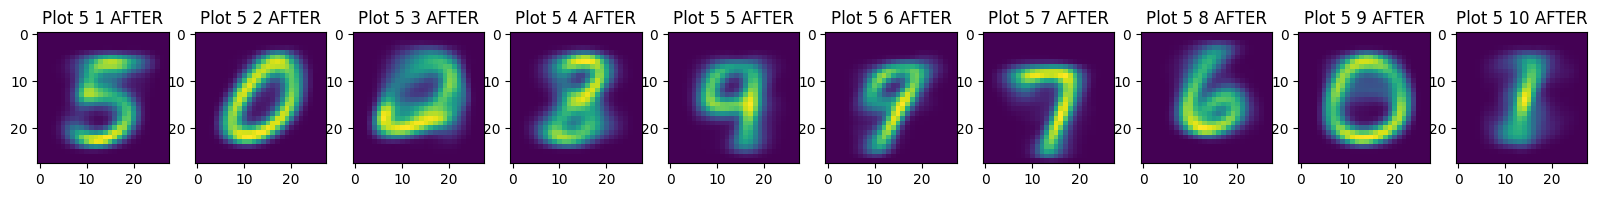

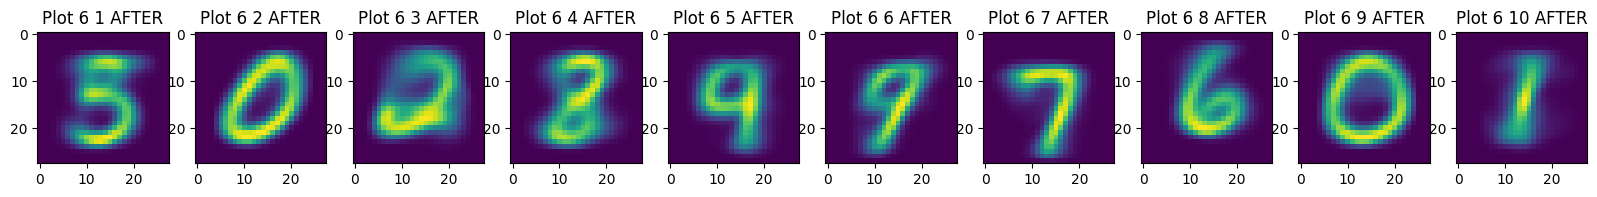

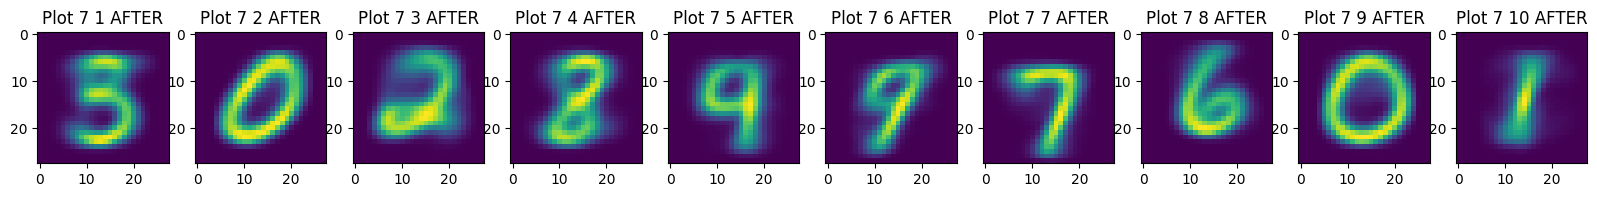

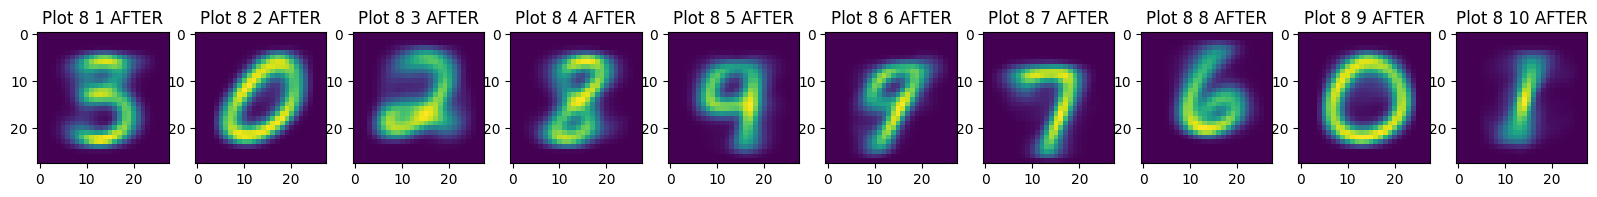

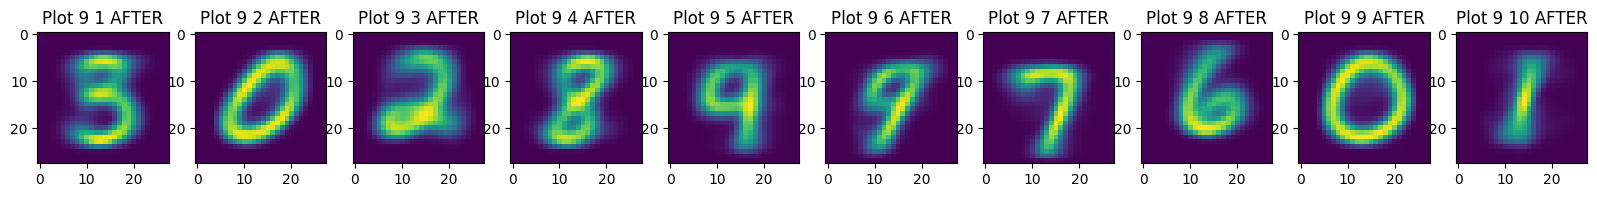

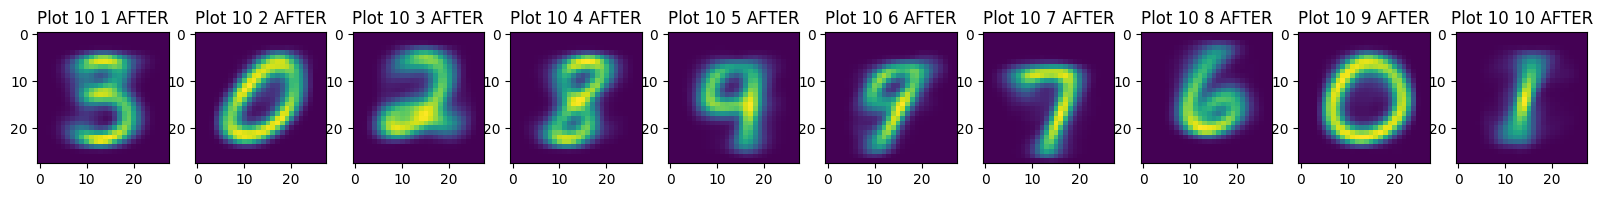

In [29]:
tol=0.05 # experiment with this
K=10

prev_error = float("inf")
curr_error = float("inf")

N = len(x_train)
counter = 0

fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i in range(10):
  axs[i].imshow(centroids_2[i].reshape((28,28)))
  axs[i].set_title(f'Plot {i+1} BEFORE') 

for i in range(10):
  counter +=1
  # print("COUNTER:", counter)
  for i in range(N):
    # Calculate the distance from the data point to each centroid
    dists = [l2_dist(x_train[i], centroid) for centroid in centroids_2]
    # Assign the data point to the cluster with the nearest centroid
    assignment = dists.index(min(dists))
    cluster_assignments_2[i] = assignment

  # update centroids
  for centroid_num in range(K):
    new_centroids = np.array([x_train[cluster_assignments_2 == i].mean(axis=0) for i in range(K)])
    centroids_2 = new_centroids

  # meanerror
  meanerror = 0
  for i in range(N):
    meanerror += l2_dist(x_train[i], centroids_2[cluster_assignments_2[i]])**2
  meanerror = meanerror / len(x_train)
  curr_error = meanerror

  if abs(curr_error - prev_error) <= tol: break
  print(counter, abs(curr_error - prev_error))
  prev_error = curr_error

  fig, axs = plt.subplots(1, 10, figsize=(20, 2))
  for i in range(10):
    axs[i].imshow(centroids_2[i].reshape((28,28)))
    axs[i].set_title(f'Plot {counter} {i+1} AFTER')

# Show the plot
plt.show()

## MaxMin Initialization
Pick a first point randomly, then subsequently pick subsequent points to be as far as possible from each of the previous points. (i.e. append point with maximal minimum distance to the set of chosen points)

iter=1 err=6.759744784934505
iter=2 err=6.525378411477237
iter=3 err=6.409575690585225
iter=4 err=6.342188272431129


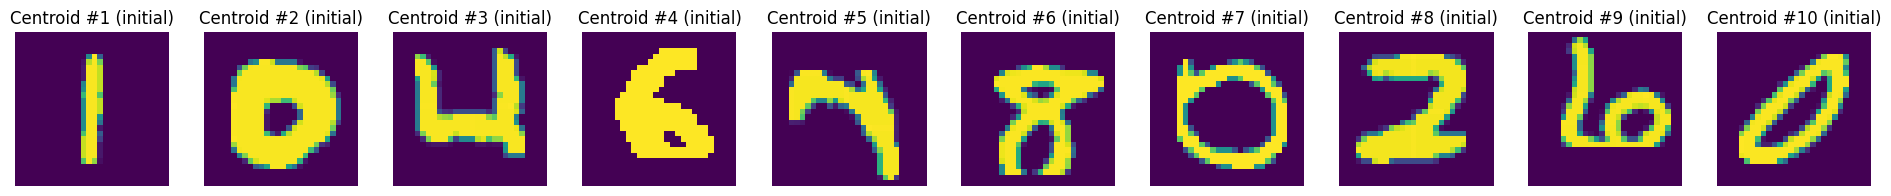

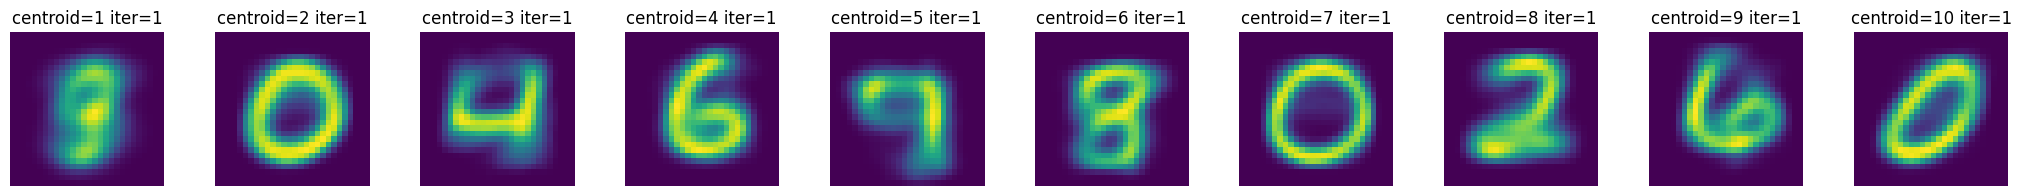

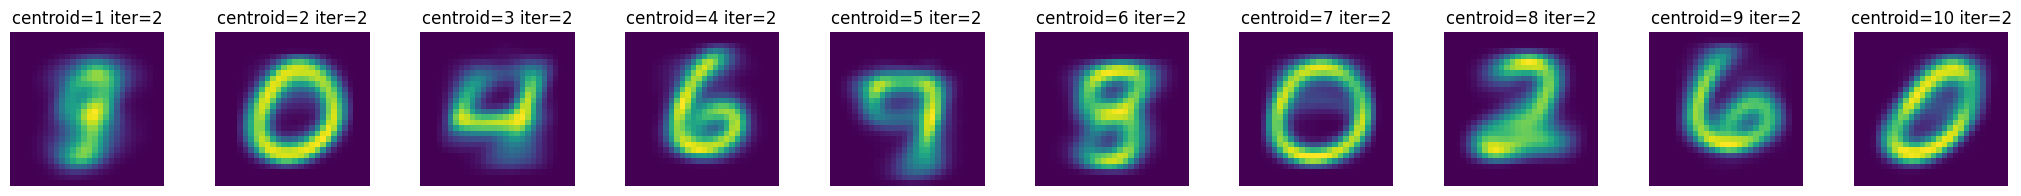

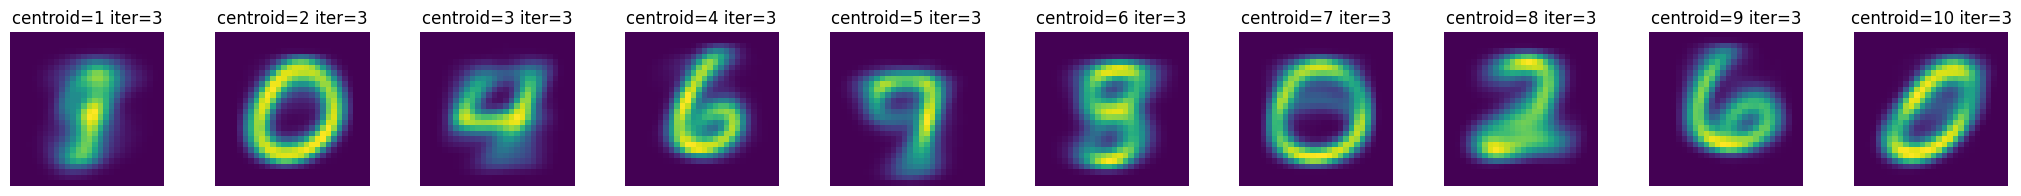

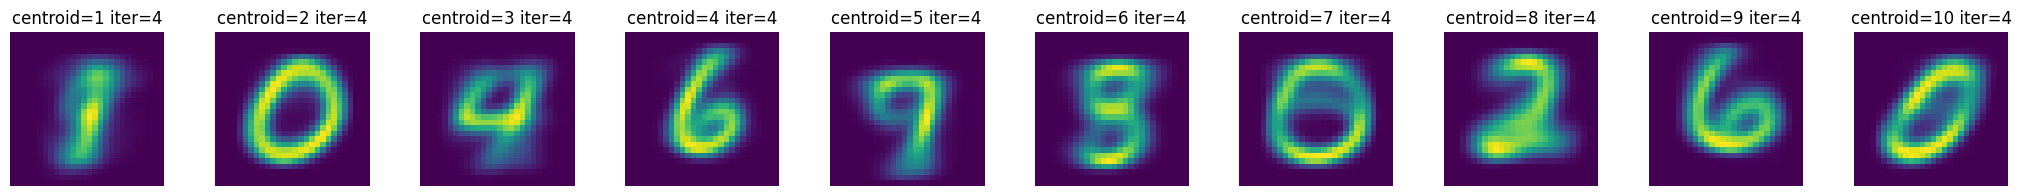

In [30]:
kmean(init_method="maxmin", dist=l2_dist, max_iters=10, tol=0.05, K=10)

# Fashion MNIST

In [10]:
import gzip
import numpy as np
import matplotlib.pyplot as plt


def load_images(path):
    with gzip.open(path, 'rb') as f:
        _, num_images, rows, cols = np.frombuffer(f.read(16), dtype=np.uint32).byteswap()
        images = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_images, rows, cols)
    return images

def load_labels(path):
    with gzip.open(path, 'rb') as f:
        _, _ = np.frombuffer(f.read(8), dtype=np.uint32).byteswap()
        labels = np.frombuffer(f.read(), dtype=np.uint8)
    return labels

path = '../data/train-labels-idx1-ubyte.gz'
y_train = load_labels(path)
print(y_train.shape)

path = '../data/train-images-idx3-ubyte.gz'
x_train = load_images(path)
print(x_train.shape)

(60000,)
(60000, 28, 28)


(<matplotlib.image.AxesImage at 0x16c7ab4d0>, 9)

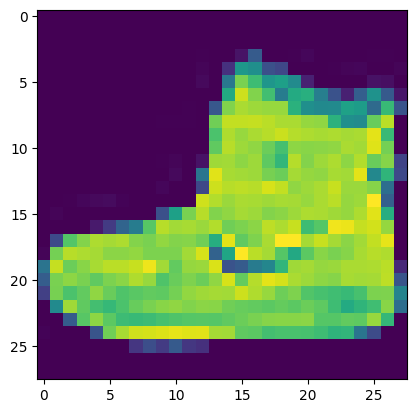

In [32]:
plt.imshow(x_train[0]), y_train[0]

iter=1 err=2041.1351735911876
iter=2 err=1643.754130941254
iter=3 err=1491.9972340912311
iter=4 err=1449.107886198777
iter=5 err=1436.9195949636078
iter=6 err=1432.9247751186651
iter=7 err=1430.6795789089883
iter=8 err=1425.7218936230183
iter=9 err=1413.9190556514525
iter=10 err=1409.6792833461996


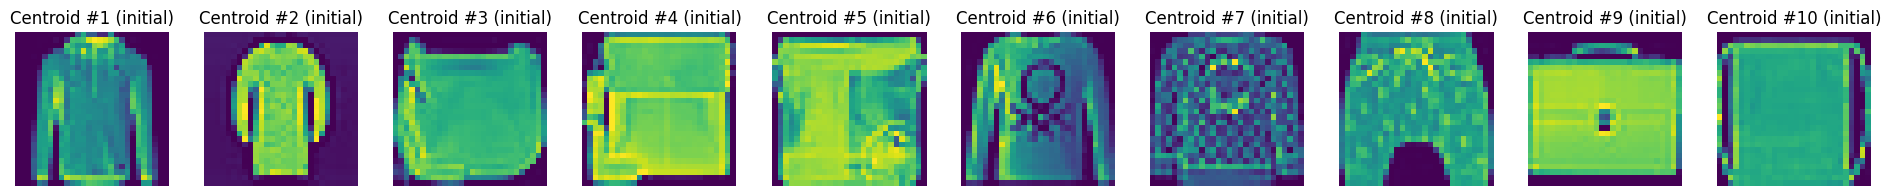

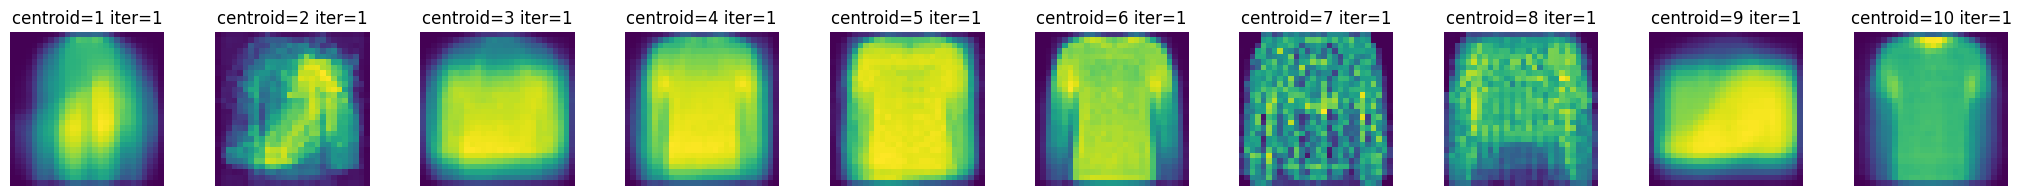

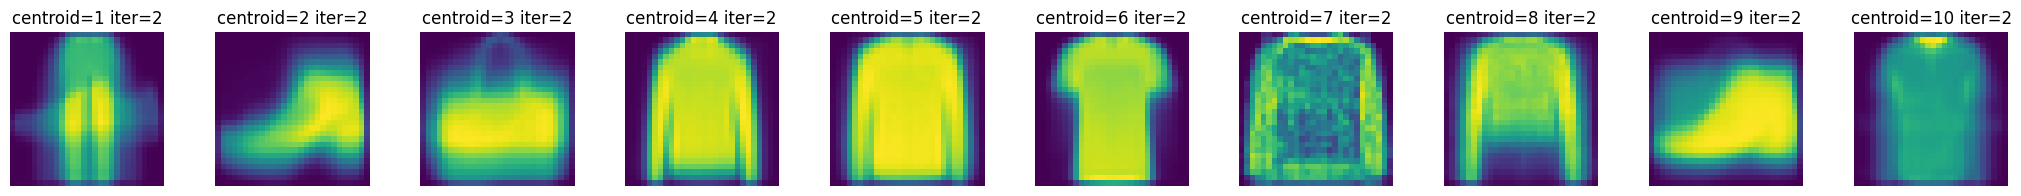

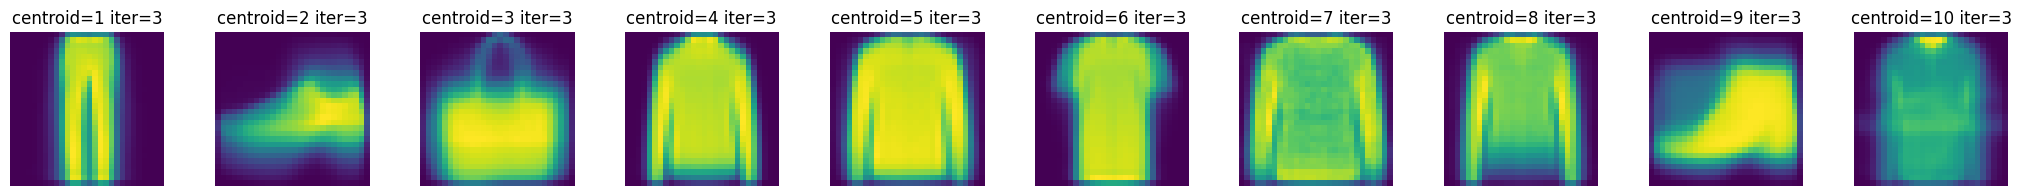

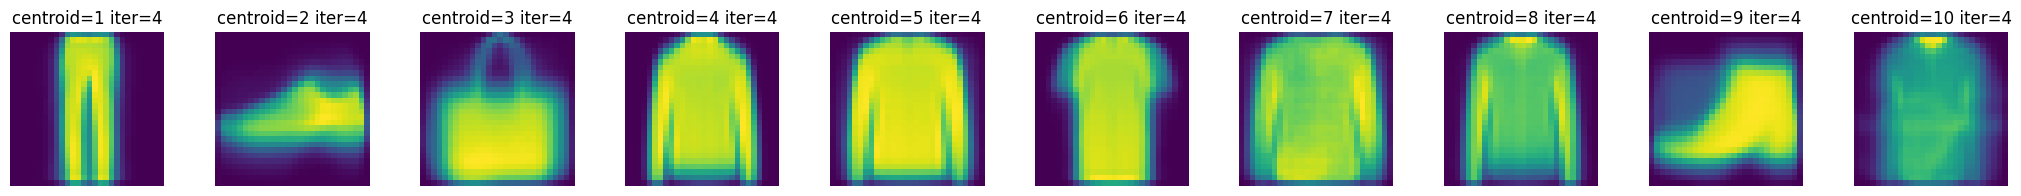

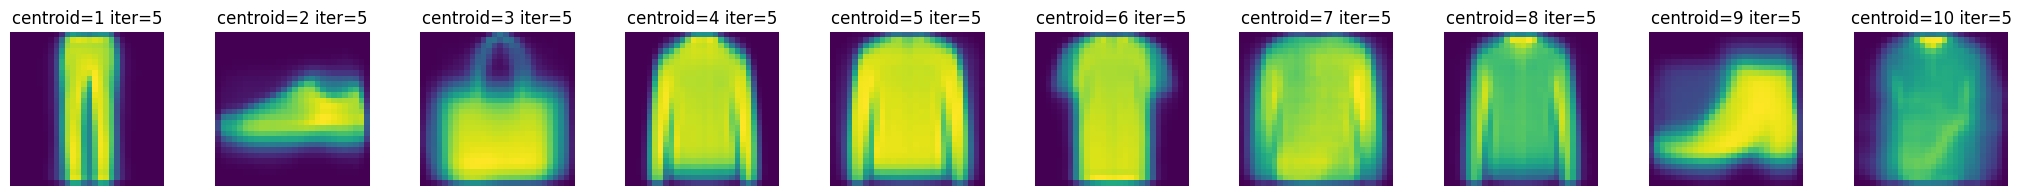

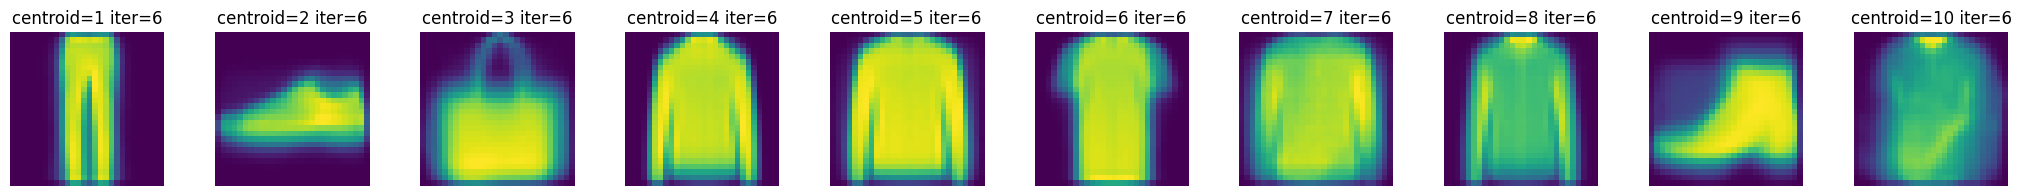

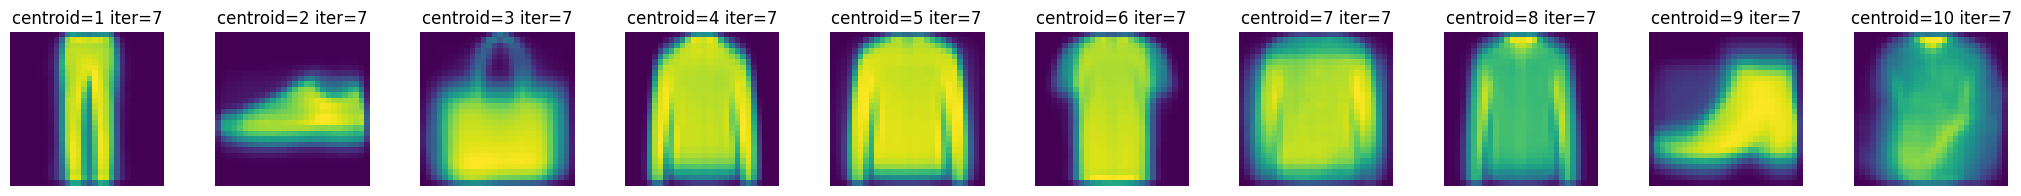

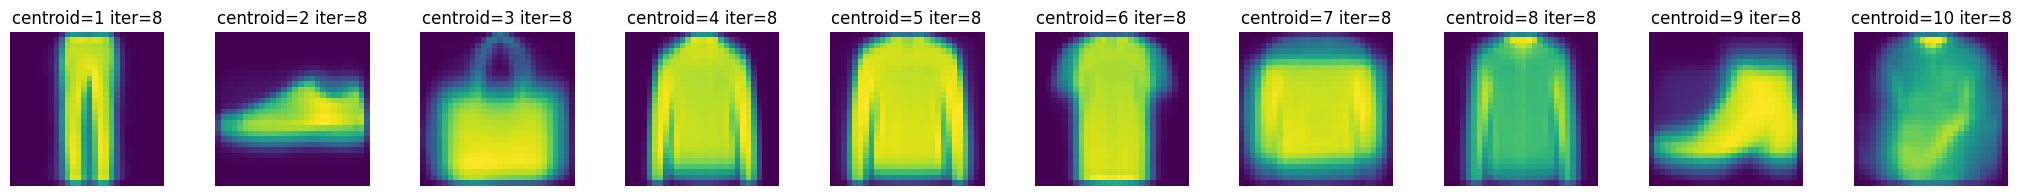

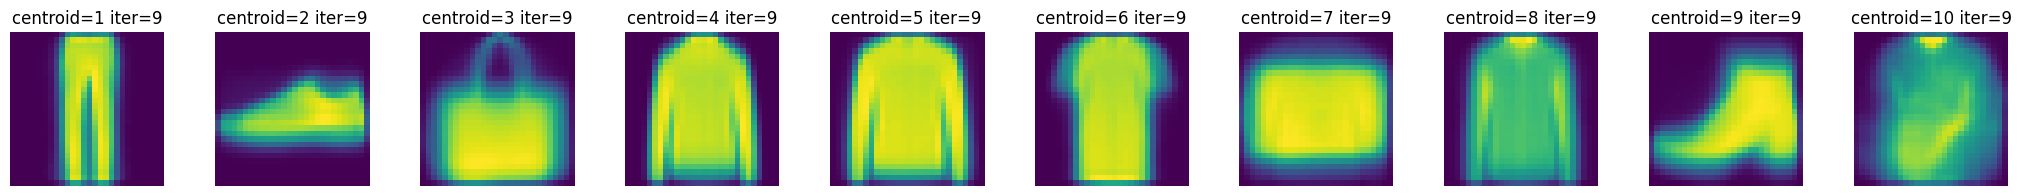

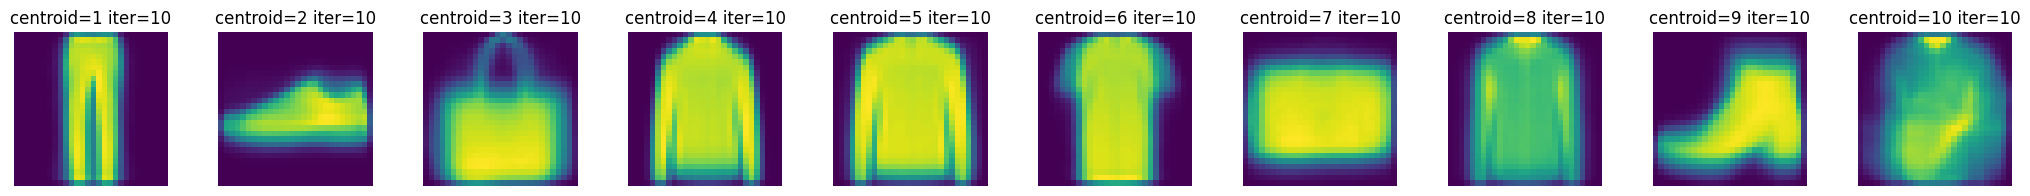

In [33]:
kmean(init_method="maxmin", dist=l2_dist, max_iters=10, tol=0.05, K=10)

iter=1 err=2061.7308109030973
iter=2 err=1959.489251195724
iter=3 err=1846.9046138708359
iter=4 err=1836.6635301259043
iter=5 err=1834.0212759592787
iter=6 err=1832.7815382383267
iter=7 err=1832.1634828155197
iter=8 err=1831.8374718081982
iter=9 err=1831.6310256531362
iter=10 err=1831.5164963691166


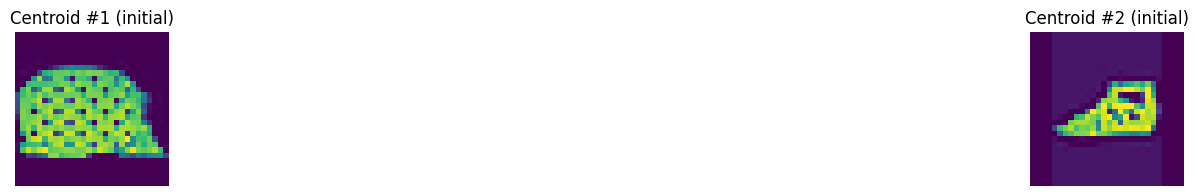

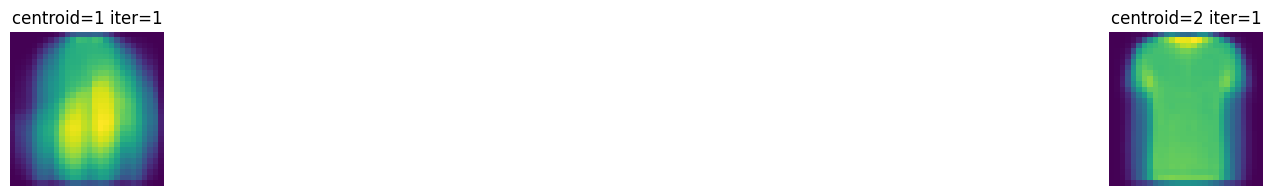

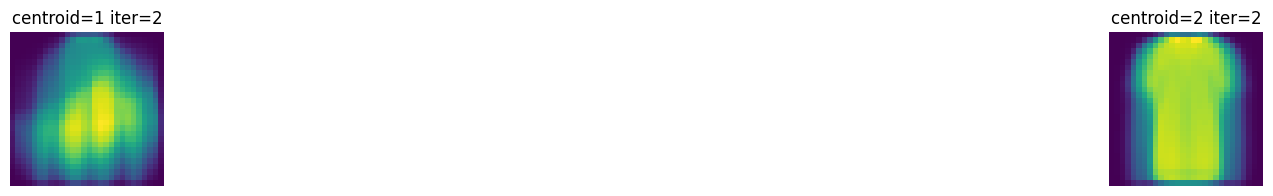

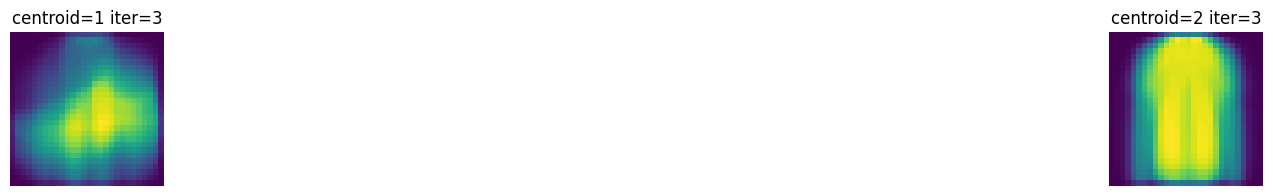

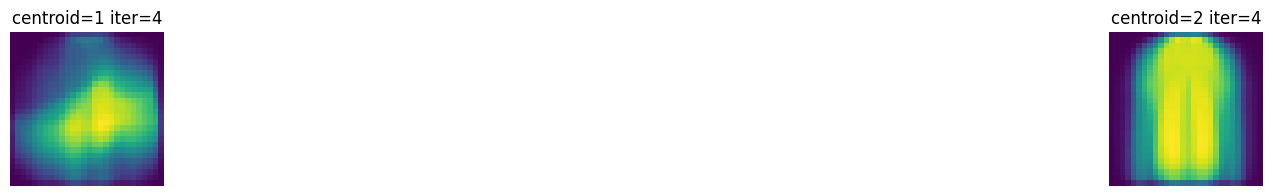

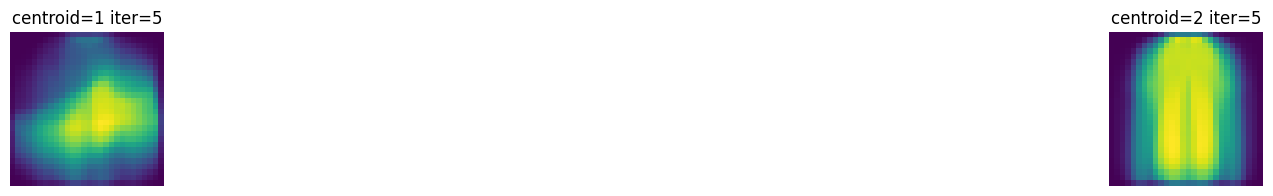

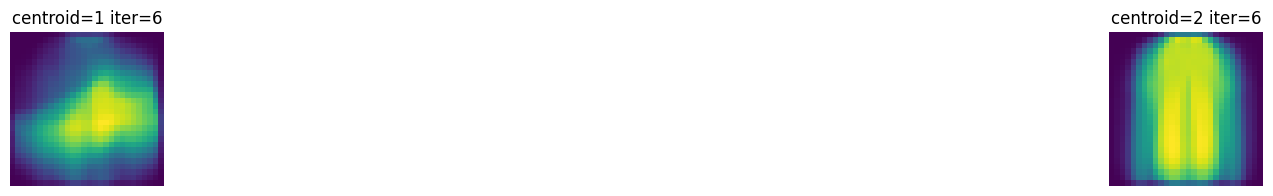

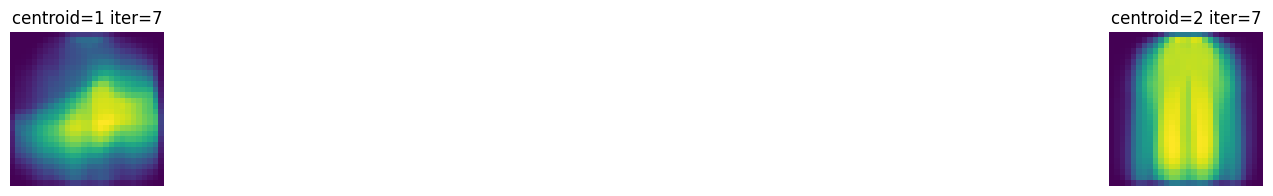

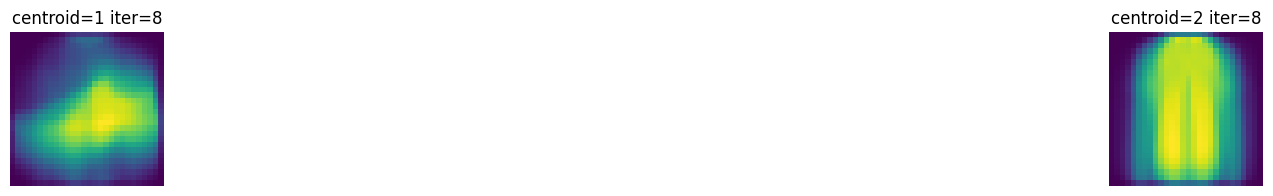

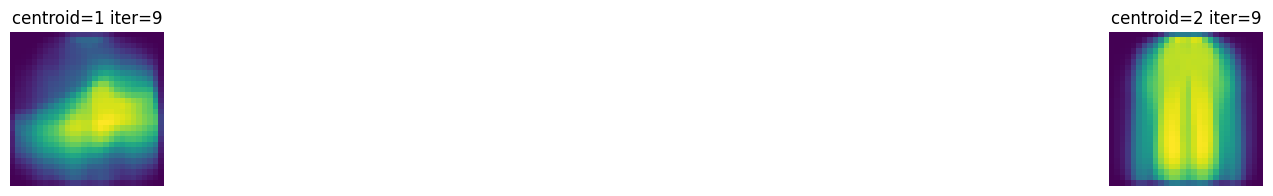

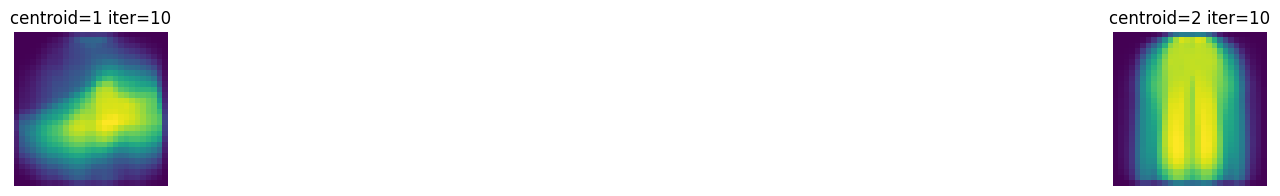

In [34]:
kmean(init_method="maxmin", dist=l2_dist, max_iters=10, tol=0.05, K=2)

# What does the average clothing item look like?

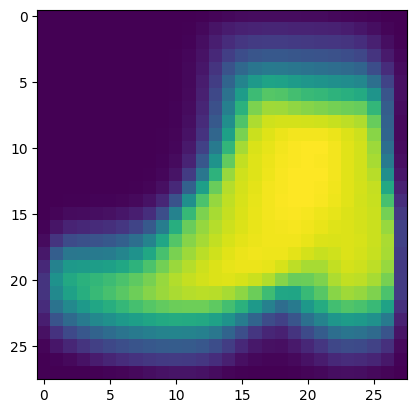

In [38]:
index = (y_train == 9) # fashion mnist shoe 
x = x_train[index]
plt.imshow(x.mean(axis=0).reshape((28, 28)))

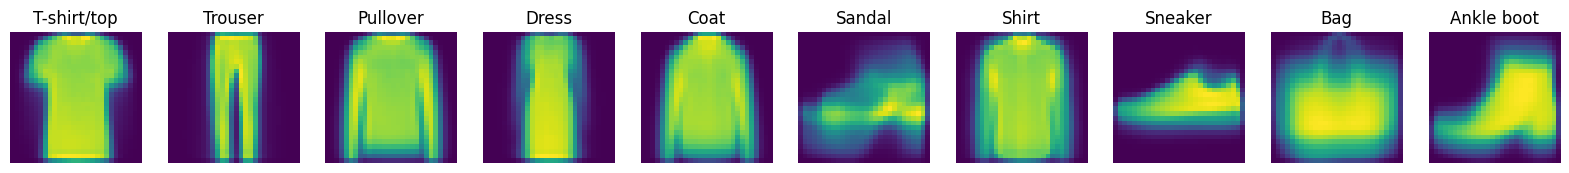

In [39]:
plt.figure(figsize=(20, 2))

fashion_mnist_labels = {
    0:'T-shirt/top',
    1:'Trouser',
    2:'Pullover',
    3:'Dress',
    4:'Coat',
    5:'Sandal',
    6:'Shirt',
    7:'Sneaker',
    8:'Bag',
    9:'Ankle boot'
}

for i in range(10):
    plt.subplot(1, 10, i + 1)
    index = (y_train == i) 
    x = x_train[index]
    plt.imshow(x.mean(axis=0).reshape((28, 28)))
    plt.title(fashion_mnist_labels[i])
    plt.axis('off')
plt.show()


iter=1 err=1739.8259285212853
iter=2 err=1501.0486240153787
iter=3 err=1464.5039926111513
iter=4 err=1447.2477848581082
iter=5 err=1433.8961666880223
iter=6 err=1422.3476333563235
iter=7 err=1414.2984880786178
iter=8 err=1410.226518469229
iter=9 err=1408.6598415396593
iter=10 err=1407.827655458475


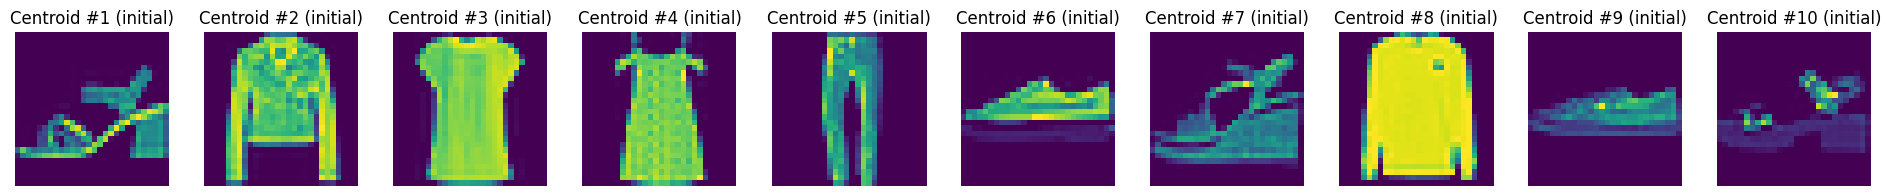

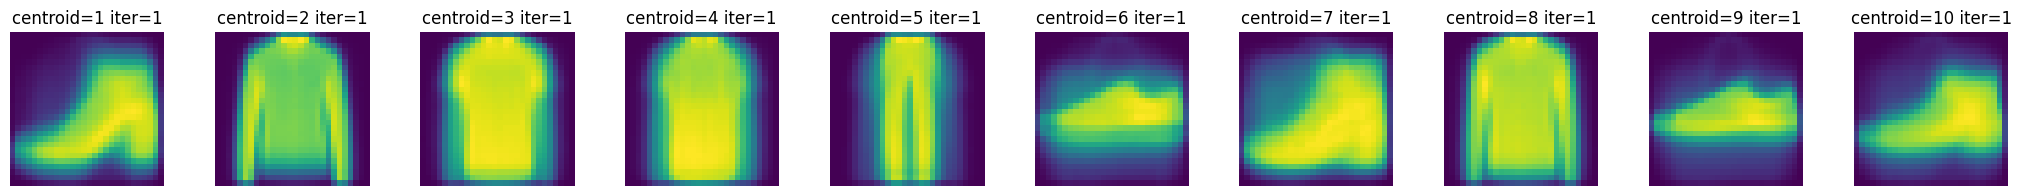

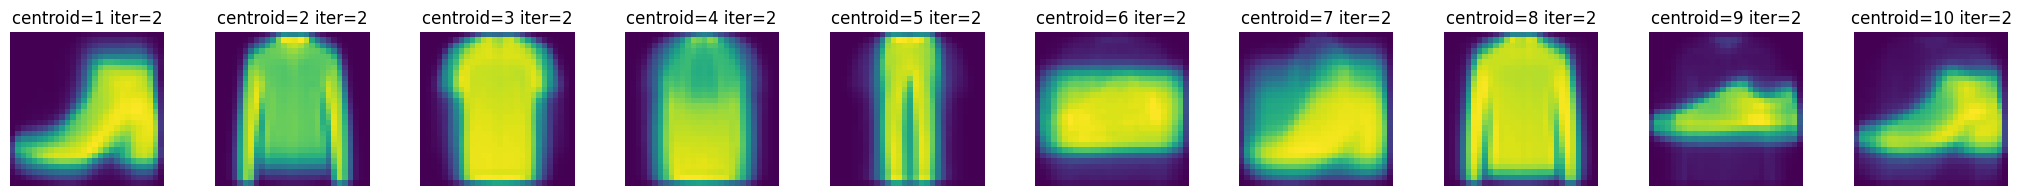

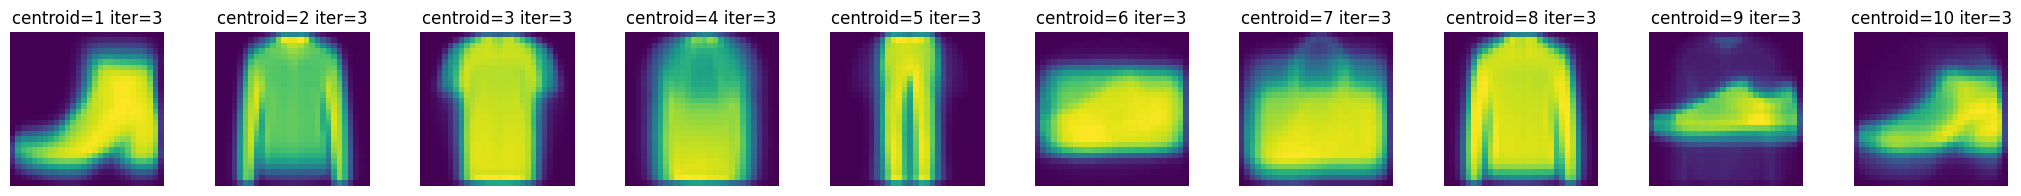

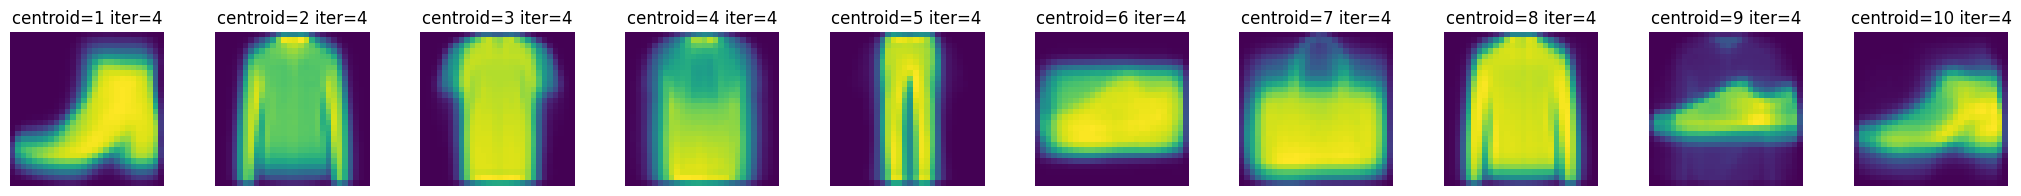

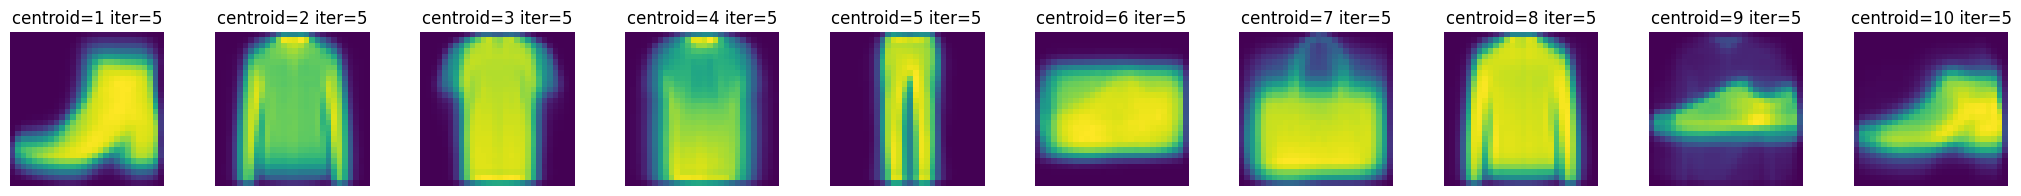

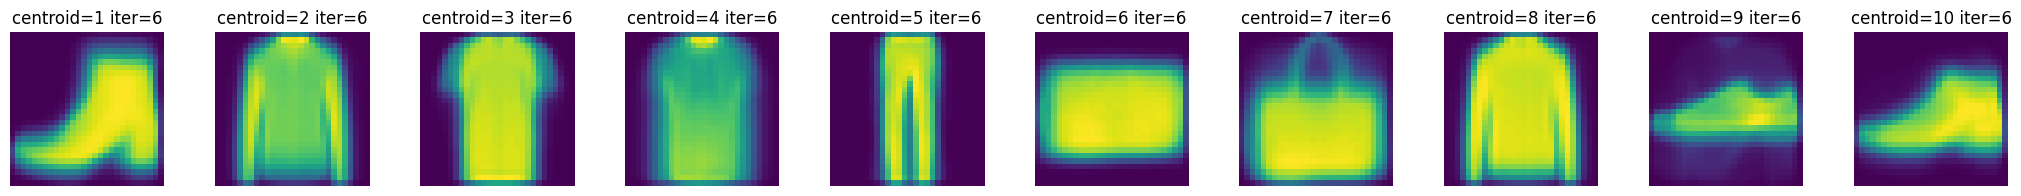

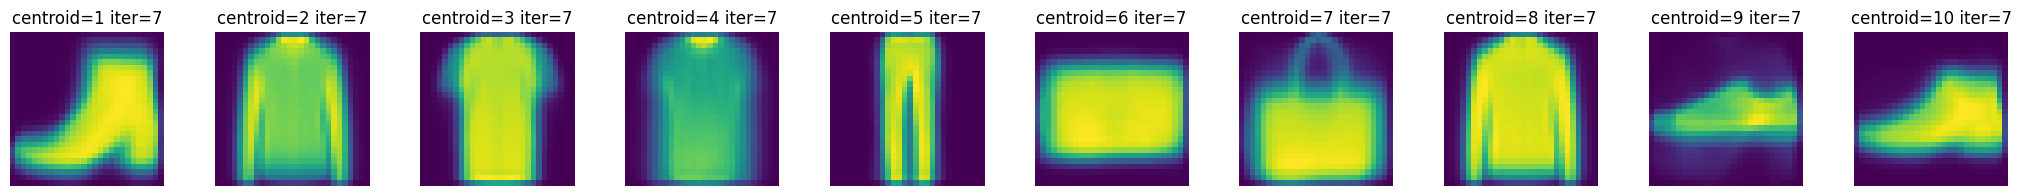

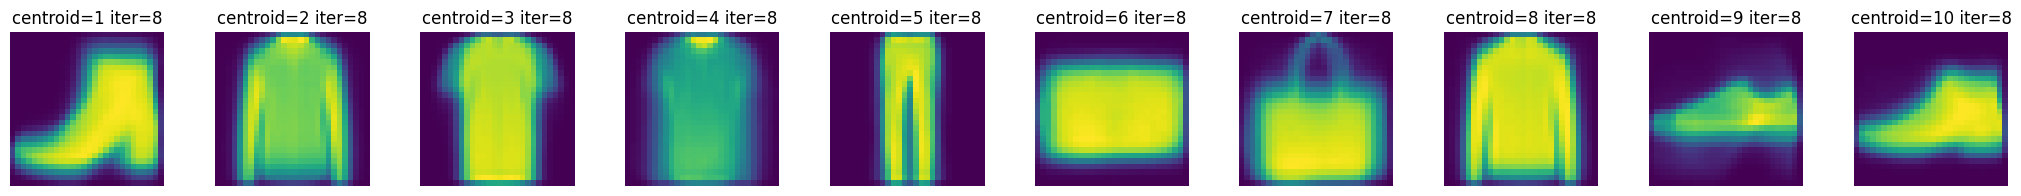

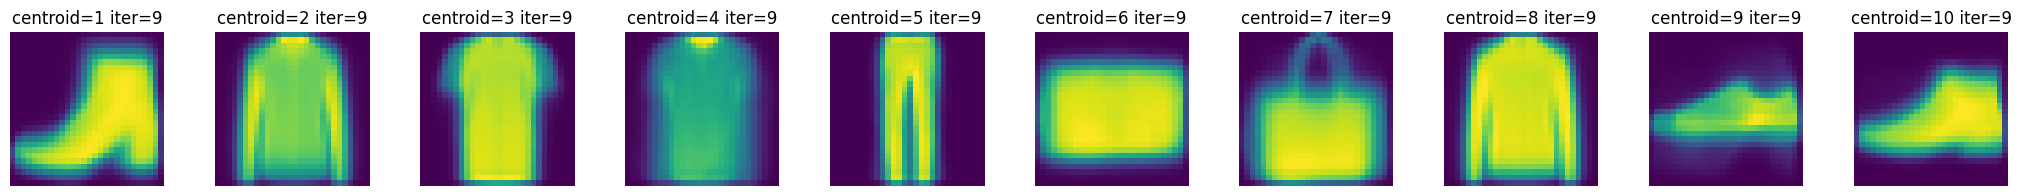

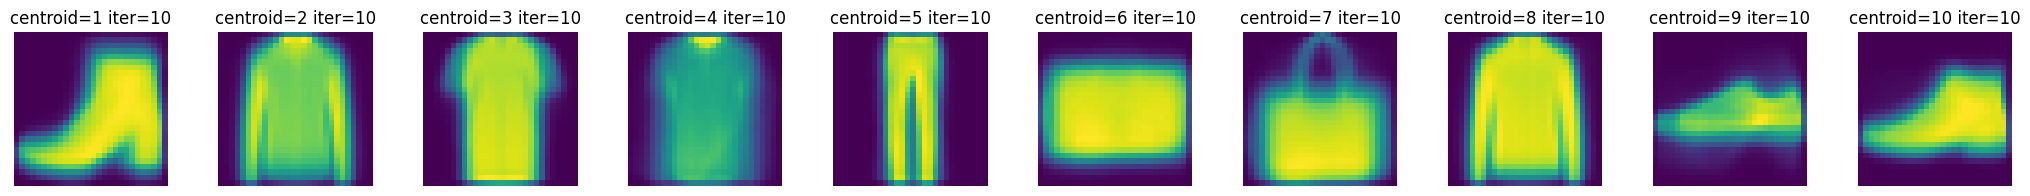

In [40]:
kmean(init_method="random", dist=l2_dist, max_iters=10, tol=0.05, K=10)

# Elbow plots: Best value of K

iter=1 err=2069.3007021216285
iter=1 err=2058.125899690868
iter=2 err=1862.3395492374796
iter=3 err=1842.9703664045337
iter=4 err=1840.0884201178058
iter=5 err=1838.6327142535094
iter=6 err=1837.6748549915792
iter=7 err=1836.924218330289
iter=8 err=1836.2214759888202
iter=9 err=1835.5412564386495
iter=10 err=1834.8408812138746
iter=1 err=1889.0918465368031
iter=2 err=1700.3943580488472
iter=3 err=1692.941102909172
iter=4 err=1691.8966452501745
iter=5 err=1691.2386893652397
iter=6 err=1690.7641777981125
iter=7 err=1690.4414720682519
iter=8 err=1690.200160492069
iter=9 err=1690.0448379010443
iter=10 err=1689.936031621254
iter=1 err=1859.4663860499104
iter=2 err=1663.094701304526
iter=3 err=1643.2593871387305
iter=4 err=1638.4039504099146
iter=5 err=1636.212985689205
iter=6 err=1634.9481582605624
iter=7 err=1634.2298290882852
iter=8 err=1633.8562753164956
iter=9 err=1633.6422581259862
iter=10 err=1633.5051133559143
iter=1 err=1765.23060690883
iter=2 err=1594.3783145969358
iter=3 err=1580.

Text(0, 0.5, 'Best Reconstruction Error')

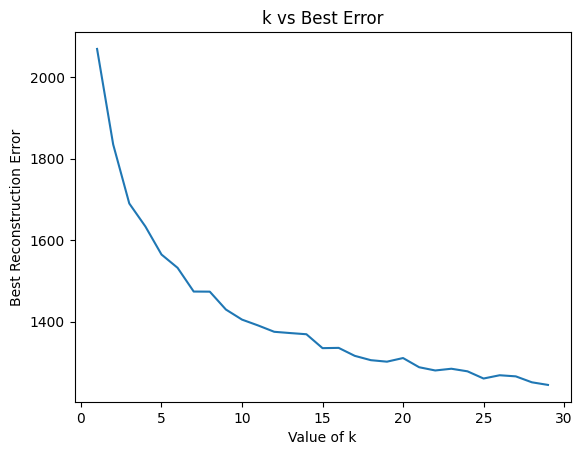

In [47]:
best = []
max_num = 30
for k_val in range(1,max_num):
    min_error = float("inf")
    meanerror = kmean(init_method="random", dist=l2_dist, max_iters=10, tol=0.05, K=k_val, do_plot=False)
    best.append(meanerror)
print(best)

# scatter plot
plt.plot([k for k in range(1,max_num)], best)
plt.title("k vs Best Error")
plt.xlabel("Value of k")
plt.ylabel("Best Reconstruction Error")

# 2D Plot -> how would we plot these?

In [50]:
a = x.mean(axis=0)#.reshape((28, 28))
b = x.mean(axis=1)#.reshape((28, 28))
print(a.shape, b.shape)
# print centroids

# plt.plot(a, b)
# plt.x_label("Axis 0")
# plt.y_label("Axis 1")
# plt.title("Axis 1 vs Axis 2 Clusters and centroids")

(28, 28) (6000, 28)


iter=1 err=2069.3007021216285
iter=1 err=2038.4729613291263
iter=2 err=1878.7361750888724
iter=3 err=1849.1610123407595
iter=4 err=1842.5967755762706
iter=5 err=1840.0679054569614
iter=6 err=1838.6706091982971
iter=7 err=1837.748548326878
iter=8 err=1837.0160859999376
iter=9 err=1836.332119242468
iter=10 err=1835.6824743472487
iter=1 err=2014.7004434388864
iter=2 err=1763.6324853442766
iter=3 err=1740.7260416608262
iter=4 err=1735.036927237657
iter=5 err=1732.5773417300297
iter=6 err=1731.064467145528
iter=7 err=1729.815315581166
iter=8 err=1728.3883699001622
iter=9 err=1726.229523301052
iter=10 err=1722.632835420867
iter=1 err=2001.5519314601358
iter=2 err=1700.6385068907284
iter=3 err=1655.8143557632511
iter=4 err=1636.7388340028162
iter=5 err=1623.3144430200966
iter=6 err=1616.5524447934556
iter=7 err=1613.5514700898134
iter=8 err=1612.164017215213
iter=9 err=1611.4733545679871
iter=10 err=1611.1249681410686
iter=1 err=1777.3850217865904
iter=2 err=1638.20834772089
iter=3 err=1617.4

Text(0, 0.5, 'Best Reconstruction Error')

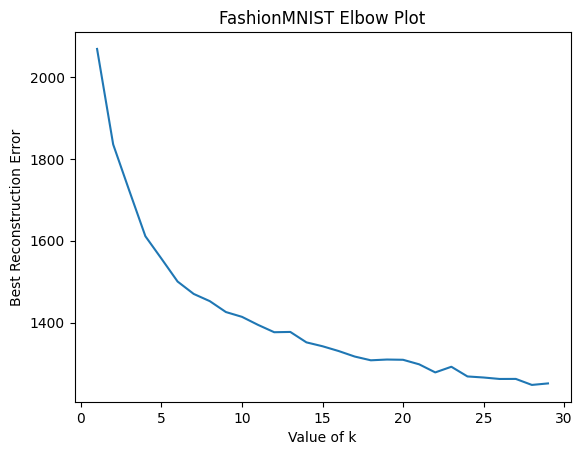

In [11]:
best = []
max_num = 30
for k_val in range(1,max_num):
    min_error = float("inf")
    meanerror = kmean(init_method="random", dist=l2_dist, max_iters=10, tol=0.05, K=k_val, do_plot=False)
    best.append(meanerror)
print(best)

# scatter plot
plt.plot([k for k in range(1,max_num)], best)
plt.title("FashionMNIST Elbow Plot")
plt.xlabel("Value of k")
plt.ylabel("Best Reconstruction Error")

In [12]:
# Load the MNIST dataset from mnist.npz file
with np.load('../data/mnist.npz') as f:
    x_train, y_train = f['x_train'], f['y_train']
    x_test, y_test = f['x_test'], f['y_test']

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


iter=1 err=1834.5829379415338
iter=1 err=1824.31647475617
iter=2 err=1787.686186168413
iter=3 err=1784.8659572351453
iter=4 err=1783.0181502957746
iter=5 err=1781.437458499151
iter=6 err=1780.061020549617
iter=7 err=1778.7894252417184
iter=8 err=1777.706914880041
iter=9 err=1776.8015233259628
iter=10 err=1776.0861478783065
iter=1 err=1827.1345305630964
iter=2 err=1764.212310501532
iter=3 err=1748.0753106045825
iter=4 err=1742.0520455791482
iter=5 err=1738.387173292594
iter=6 err=1735.6494039821412
iter=7 err=1733.6810078934473
iter=8 err=1732.2222791509396
iter=9 err=1730.8594197713128
iter=10 err=1729.5613500136706
iter=1 err=1814.7780567141854
iter=2 err=1735.3522520666663
iter=3 err=1717.301254849559
iter=4 err=1709.2523261169245
iter=5 err=1704.6165986247631
iter=6 err=1701.8169364459127
iter=7 err=1700.016874742672
iter=8 err=1698.7851953294053
iter=9 err=1697.872911028643
iter=10 err=1697.0898238541618
iter=1 err=1834.2865718010617
iter=2 err=1789.1834623317516
iter=3 err=1730.07

Text(0, 0.5, 'Best Reconstruction Error')

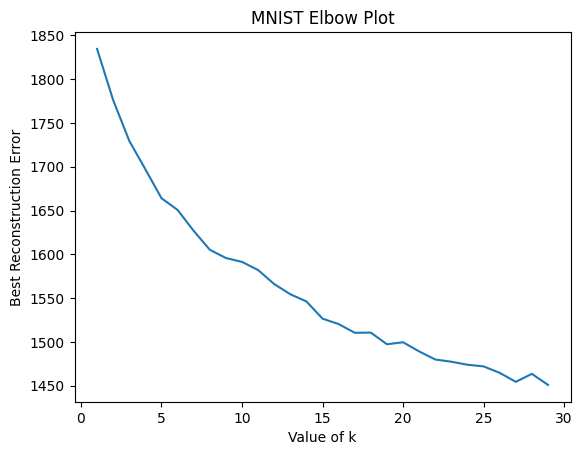

In [13]:
best = []
max_num = 30
for k_val in range(1,max_num):
    min_error = float("inf")
    meanerror = kmean(init_method="random", dist=l2_dist, max_iters=10, tol=0.05, K=k_val, do_plot=False)
    best.append(meanerror)
print(best)

# scatter plot
plt.plot([k for k in range(1,max_num)], best)
plt.title("MNIST Elbow Plot")
plt.xlabel("Value of k")
plt.ylabel("Best Reconstruction Error")